In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import one_hot
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
sns.set_theme()

In [2]:
df = pd.read_csv('HTRU_2.csv',
                 names=['feat0', 'feat1', 'feat2', 'feat3', 
                        'feat4', 'feat5', 'feat6', 'feat7', 'target'])

In [3]:
def get_feat_targ(data=df) -> (pd.core.frame.DataFrame, pd.core.frame.DataFrame):
    
    """
    data variable is original data containing the label
    """
    
    if not isinstance(data, pd.core.frame.DataFrame):
        raise TypeError("type must be pandas DataFrame")
        
    else:
        return data.iloc[:, :-1], data.iloc[:, -1:] 

In [4]:
features_df, target_df = get_feat_targ(df)

len(features_df)

17898

# Lets find all contradictions, duplicates and omissions in data

In [5]:
def finding_contradiction(datafr=df) -> pd.core.frame.DataFrame: 
    """
    checking for contradiction
    
    datafr is original data containing the label
    """
    
    if not isinstance(datafr, pd.core.frame.DataFrame):
        raise TypeError("type must be pandas DataFrame")

    else:
        features_df = datafr.iloc[:, :-1]
        return features_df[features_df.duplicated()] 

    
def finding_duplicates(datafr=df) -> pd.core.frame.DataFrame: 
    """
    checking for duplicates 
    
    datafr is original data containing the label
    """
    
    if not isinstance(datafr, pd.core.frame.DataFrame):
        raise TypeError("type must be pandas DataFrame")
    else:
        return datafr[datafr.duplicated()]
    
    
def finding_omissons(datafr=df) -> pd.core.frame.Series:
    """
    checking for omissions in each column and everywhere
    
    datafr is original data containing the label
    """
    
    if not isinstance(datafr, pd.core.frame.DataFrame):
        raise TypeError("type must be pandas DataFrame")
    else:
        return (datafr.isnull().sum(),  
                datafr.isnull().sum().sum())

In [6]:
finding_contradiction(df)

Empty DataFrame
Columns: [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7]
Index: []

In [7]:
finding_duplicates(df)

Empty DataFrame
Columns: [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7, target]
Index: []

In [8]:
finding_omissons(df)

(feat0     0
 feat1     0
 feat2     0
 feat3     0
 feat4     0
 feat5     0
 feat6     0
 feat7     0
 target    0
 dtype: int64,
 0)

# Distribution Histograms and Box-and-Whisker Plots

In [9]:
features_df


feat0      feat1     feat2     feat3       feat4      feat5  \
0      140.562500  55.683782 -0.234571 -0.699648    3.199833  19.110426   
1      102.507812  58.882430  0.465318 -0.515088    1.677258  14.860146   
2      103.015625  39.341649  0.323328  1.051164    3.121237  21.744669   
3      136.750000  57.178449 -0.068415 -0.636238    3.642977  20.959280   
4       88.726562  40.672225  0.600866  1.123492    1.178930  11.468720   
...           ...        ...       ...       ...         ...        ...   
17893  136.429688  59.847421 -0.187846 -0.738123    1.296823  12.166062   
17894  122.554688  49.485605  0.127978  0.323061   16.409699  44.626893   
17895  119.335938  59.935939  0.159363 -0.743025   21.430602  58.872000   
17896  114.507812  53.902400  0.201161 -0.024789    1.946488  13.381731   
17897   57.062500  85.797340  1.406391  0.089520  188.306020  64.712562   

           feat6       feat7  
0       7.975532   74.242225  
1      10.576487  127.393580  
2       7.735822   63.171909  
3       6.896499   53.593661  
4      14.269573  252.567306  
...          ...         ...  
17893  15.450260  285.931022  
17894   2.945244    8.297092  
17895   2.499517    4.595173  
17896  10.007967  134.238910  
17897  -1.597527    1.429475  

[17898 rows x 8 columns]

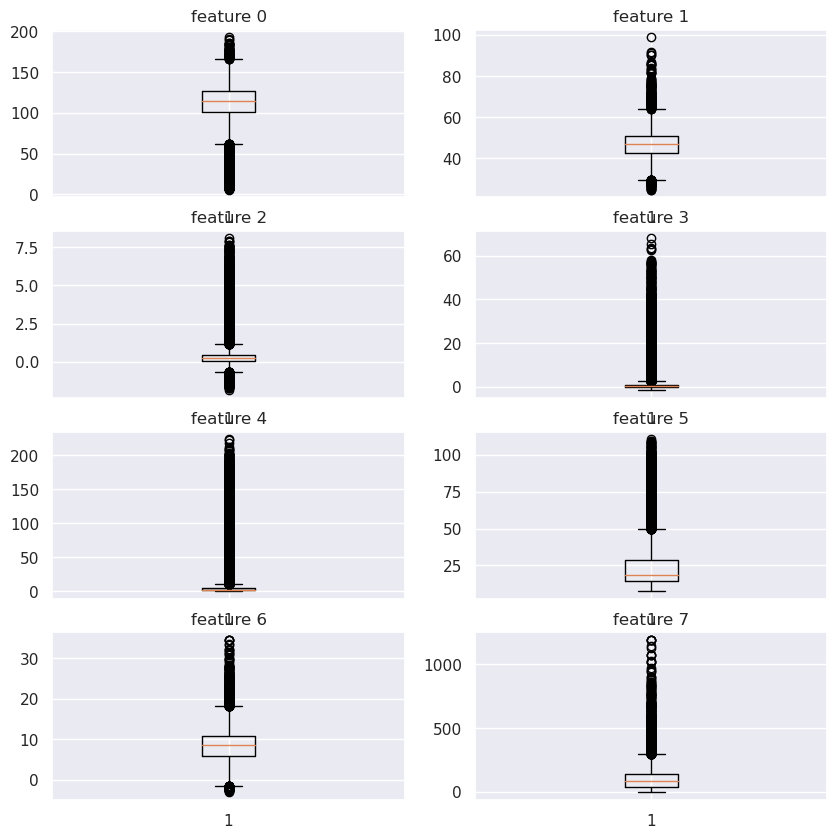

In [10]:
nrows = 4
ncols = 2
Fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
for rows in range(nrows):
    for cols in range(ncols):    
        axs[rows, cols].boxplot(df.iloc[:, rows * ncols + cols])
        axs[rows, cols].set_title(f'feature {rows * ncols + cols}')

<Axes: >

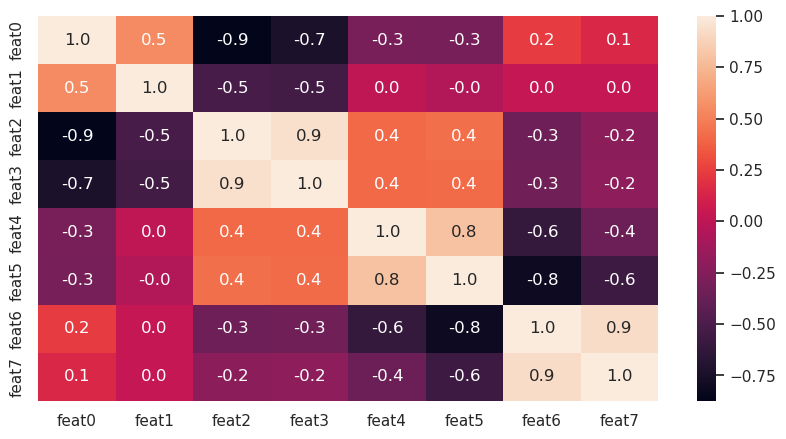

In [11]:
plt.figure(figsize=[10, 5])
sns.heatmap(features_df.corr(), annot=True, fmt='.1f')

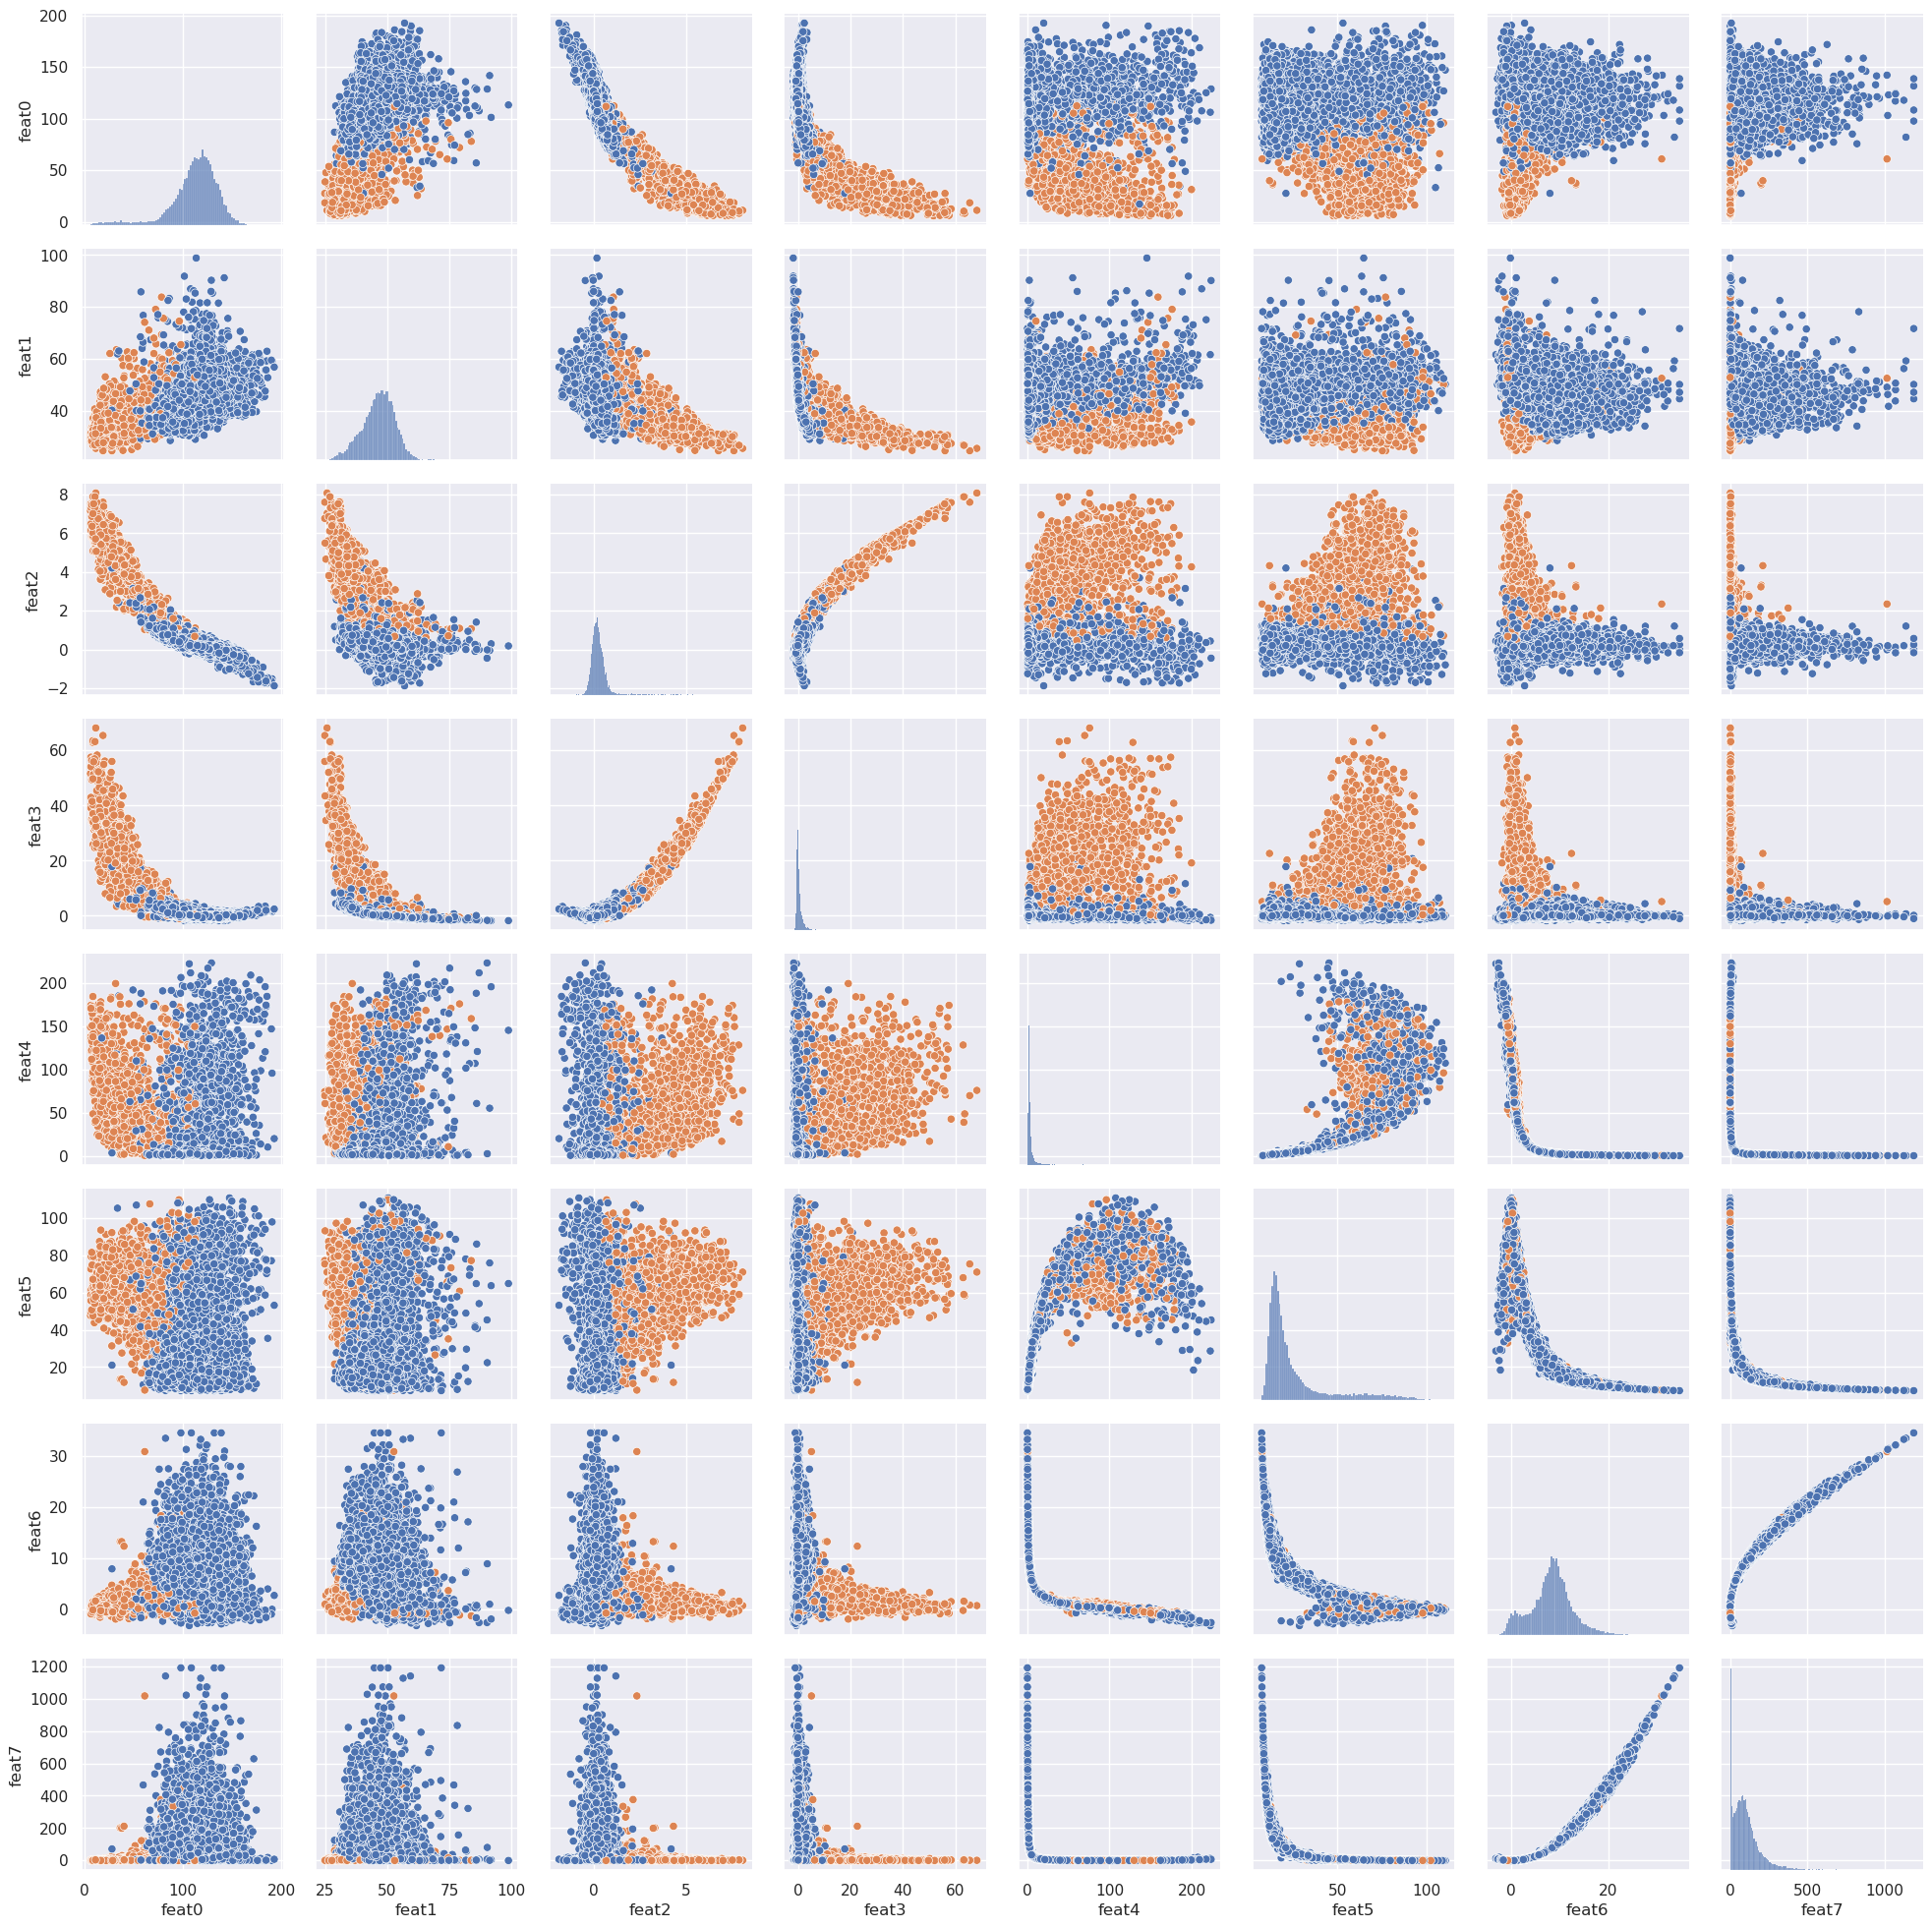

In [12]:
g = sns.PairGrid(features_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, hue=np.array(target_df).squeeze())

In [15]:
def normalize_data(datafr=df) -> pd.core.frame.DataFrame: 
    """
    remove emissions
    
    datafr is original data containing the label
    """
    
    if not isinstance(datafr, pd.core.frame.DataFrame):
        raise TypeError("type must be pandas DataFrame")

    else:
        for i in range(len(datafr.columns) - 1):
            Q1, Q3 = datafr.iloc[:, i].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            datafr = datafr[(datafr.iloc[:, i] >= Q1 - IQR * 1.5) & (datafr.iloc[:, i] <= Q3 + IQR * 1.5 )]
        return datafr

In [16]:
new_columns = ['feat0', 'feat1', 'feat3', 'feat4', 'feat5', 'feat7', 'target']
df_new = df[new_columns]

In [17]:
features_df_new = df_new.iloc[:, :-1]
target_df_new = df_new.iloc[:, -1:]

features_df_new

feat0      feat1     feat3       feat4      feat5       feat7
0      140.562500  55.683782 -0.699648    3.199833  19.110426   74.242225
1      102.507812  58.882430 -0.515088    1.677258  14.860146  127.393580
2      103.015625  39.341649  1.051164    3.121237  21.744669   63.171909
3      136.750000  57.178449 -0.636238    3.642977  20.959280   53.593661
4       88.726562  40.672225  1.123492    1.178930  11.468720  252.567306
...           ...        ...       ...         ...        ...         ...
17893  136.429688  59.847421 -0.738123    1.296823  12.166062  285.931022
17894  122.554688  49.485605  0.323061   16.409699  44.626893    8.297092
17895  119.335938  59.935939 -0.743025   21.430602  58.872000    4.595173
17896  114.507812  53.902400 -0.024789    1.946488  13.381731  134.238910
17897   57.062500  85.797340  0.089520  188.306020  64.712562    1.429475

[17898 rows x 6 columns]

In [18]:
features_df_norm = features_df_new.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
target_df_norm = target_df_new
features_df_norm

feat0     feat1     feat3     feat4     feat5     feat7
0      1.149285  1.334794 -0.400448 -0.319431 -0.370615 -0.287430
1     -0.334159  1.802215 -0.370525 -0.371092 -0.588908  0.211576
2     -0.314363 -1.053293 -0.116590 -0.322098 -0.235322 -0.391363
3      1.000666  1.553211 -0.390167 -0.304396 -0.275659 -0.481287
4     -0.871378 -0.858855 -0.104863 -0.388000 -0.763090  1.386755
...         ...       ...       ...       ...       ...       ...
17893  0.988180  1.943230 -0.406686 -0.383999 -0.727275  1.699987
17894  0.447306  0.429050 -0.234637  0.128773  0.939899 -0.906549
17895  0.321833  1.956165 -0.407481  0.299129  1.671522 -0.941304
17896  0.133624  1.074480 -0.291033 -0.361957 -0.664838  0.275842
17897 -2.105703  5.735309 -0.272500  5.961125  1.971490 -0.971025

[17898 rows x 6 columns]

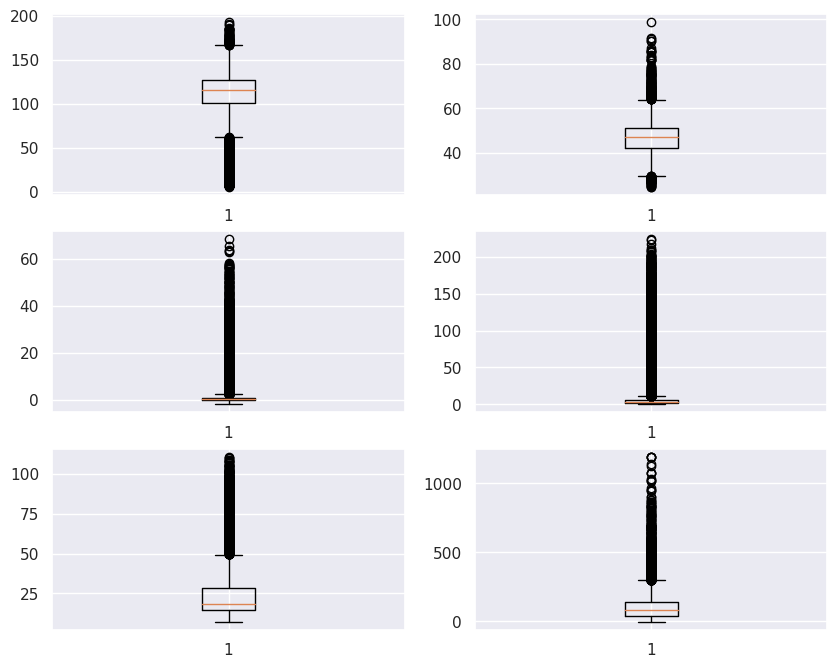

In [19]:
nrows = 3
ncols = 2
Fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
for rows in range(nrows):
    for cols in range(ncols):    
        axs[rows, cols].boxplot(df_new.iloc[:, rows * ncols + cols])

<Axes: >

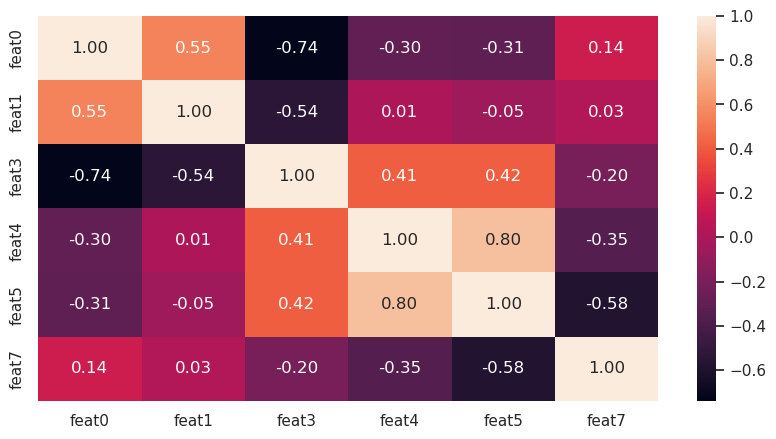

In [20]:
plt.figure(figsize=[10,5])

sns.heatmap(features_df_norm.corr(), annot=True, fmt='.2f')


<Figure size 1000x1000 with 0 Axes>

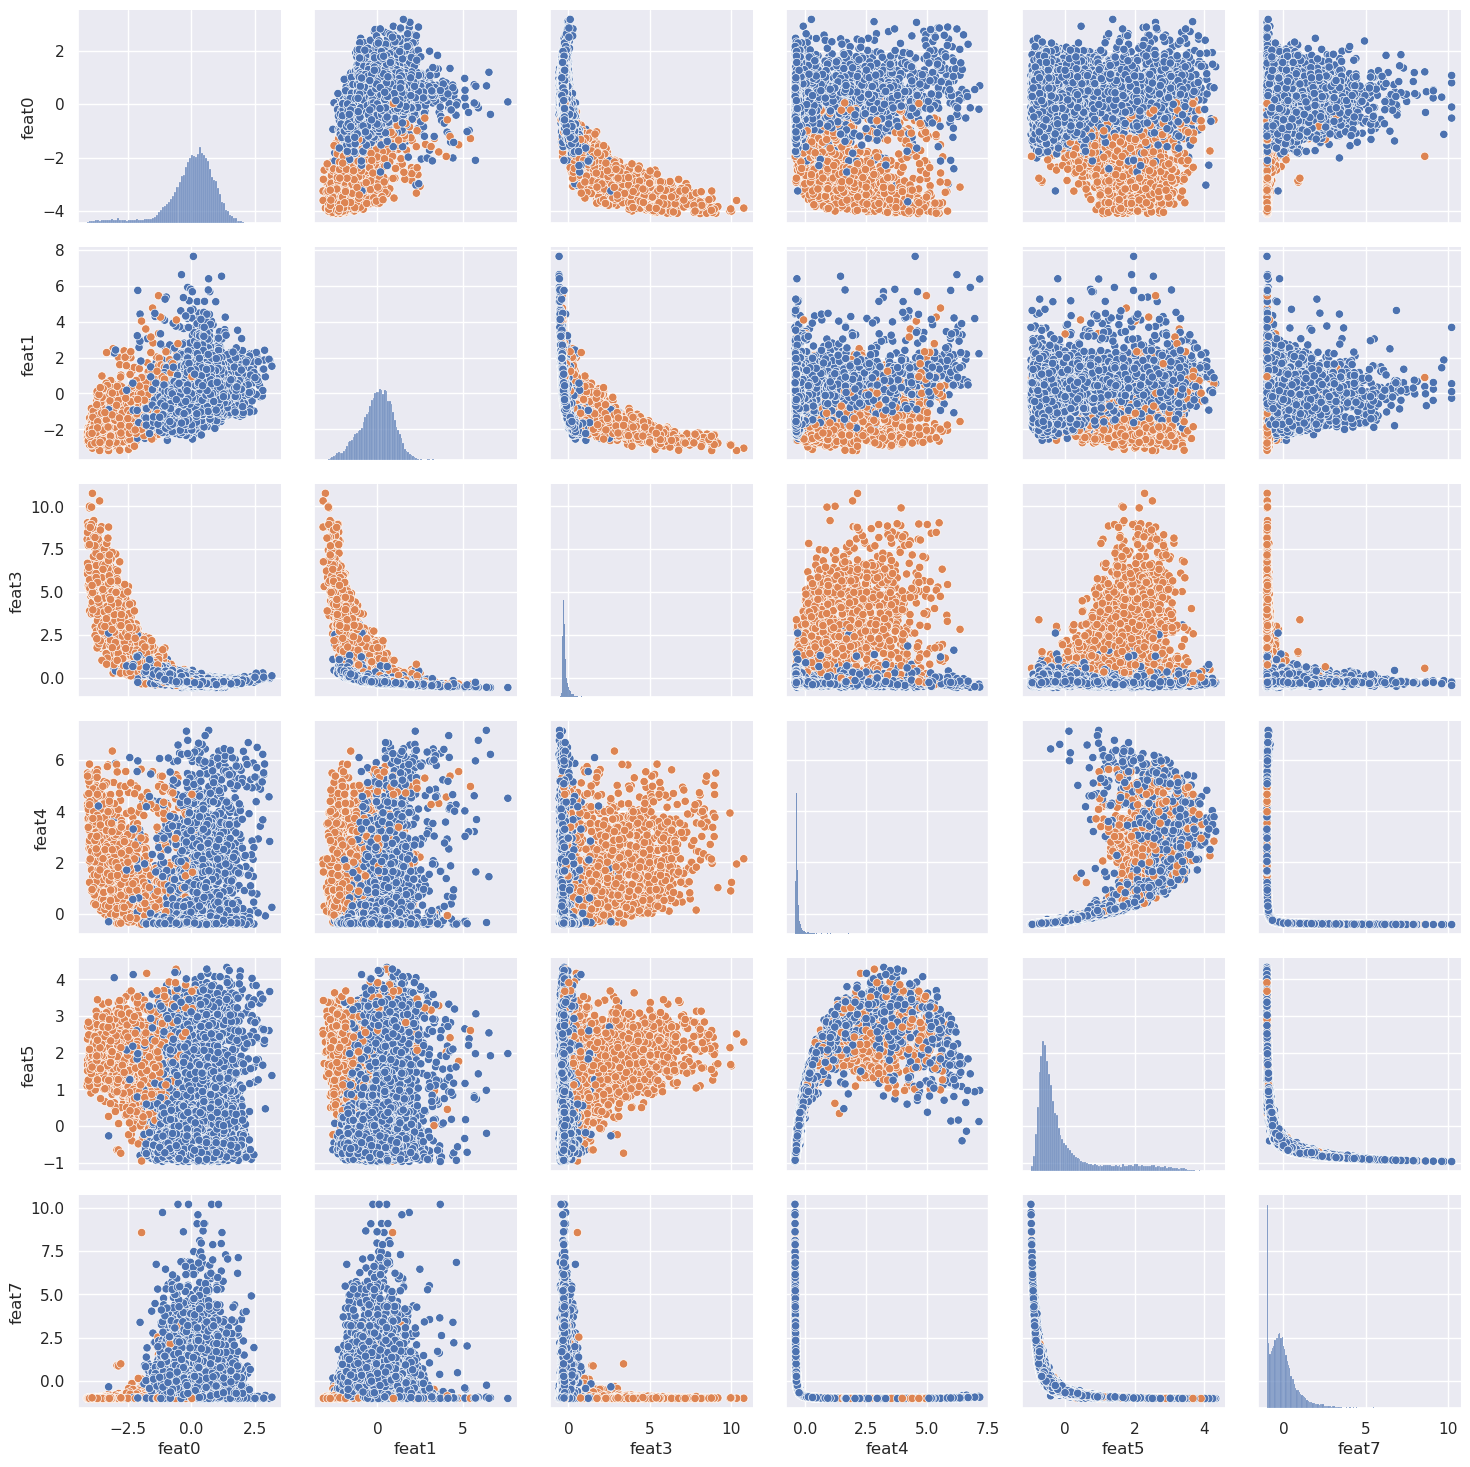

In [21]:
plt.figure(figsize=[10,10])
g = sns.PairGrid(features_df_norm)

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, hue=np.array(target_df_norm).squeeze());

In [24]:
def train_validation_test_split(X: np.ndarray, y: np.ndarray, *, train_size: float=0.6, 
                                validation_size: float=0.3, test_size: float=0.1):
    '''
    train_size, validation_size and test_size must be more than 0, less than 1
    and their sum must be equal to 1
    '''
    
    data = np.hstack((X, y))
    np.random.shuffle(data)
    

    raws,columns = X.shape
    
    train_index = round(train_size * raws)
    validation_index = round((train_size + validation_size) * raws)
    
    X_train_data= data[:train_index, :columns]
    y_train_data = data[:train_index, columns].reshape(-1, 1)
    X_validation_data = data[train_index:validation_index, :columns]
    y_validation_data = data[train_index:validation_index, columns].reshape(-1, 1)
    X_test_data = data[validation_index:, :columns]
    y_test_data = data[validation_index:, columns].reshape(-1, 1)
    
    return X_train_data, y_train_data, X_validation_data, y_validation_data, X_test_data, y_test_data
    

In [25]:
x_train, y_train, x_val, y_val, x_test, y_test = train_validation_test_split(features_df_norm, 
                                                                             target_df_norm)

In [26]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

# Creating dataset

In [27]:
train_data = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)

val_data = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
val_dataloader = DataLoader(val_data, batch_size=len(val_data))

test_data = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))
test_dataloader = DataLoader(test_data, batch_size=len(test_data))

# Creating model

In [28]:
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
class MyNet(nn.Module):
    def __init__(self, input, hidden):
        super().__init__()
        self.linear1 = nn.Linear(input, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, hidden)
        self.linear4 = nn.Linear(hidden, 1)

        self.act = nn.Sigmoid()
        self.sigmoid = nn.Sigmoid()
        self.apply(xavier_init)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)

        x = self.linear2(x)
        x = self.act(x)

        
        x = self.linear3(x)
        x = self.act(x)        

        x = self.linear4(x)
        x = self.sigmoid(x)
        
        return x

In [29]:
def classification(y_pred, y_real):
    bool_tensor = (y_pred.detach().cpu()>0.5).squeeze() != torch.flatten(y_real.detach().cpu())
    return torch.mean(bool_tensor.float())

In [30]:
def train(net, dataloader, criterion, optimizer):
    net.train()
    total_loss = 0
    classification_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(x_batch)
        loss = criterion(y_pred, y_batch)
        classification_loss += classification(y_pred, y_batch).item()
        total_loss += loss.item()
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            optimizer.step(closure)
        else: optimizer.step()
    return total_loss / len(dataloader), classification_loss / len(dataloader)


def validation(net, dataloader, criterion, optimizer):
    net.eval()
    total_loss = 0
    classification_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch) 
            classification_loss += classification(y_pred, y_batch).item()
            total_loss += loss.item()
    return total_loss / len(dataloader), classification_loss / len(dataloader)

In [31]:
mynet = MyNet(6, 10).to(device)

In [32]:
loss = nn.BCELoss()
optim = torch.optim.Adam(mynet.parameters(), lr=3e-2)

In [33]:
epochs = 1000

In [34]:
from IPython.display import clear_output

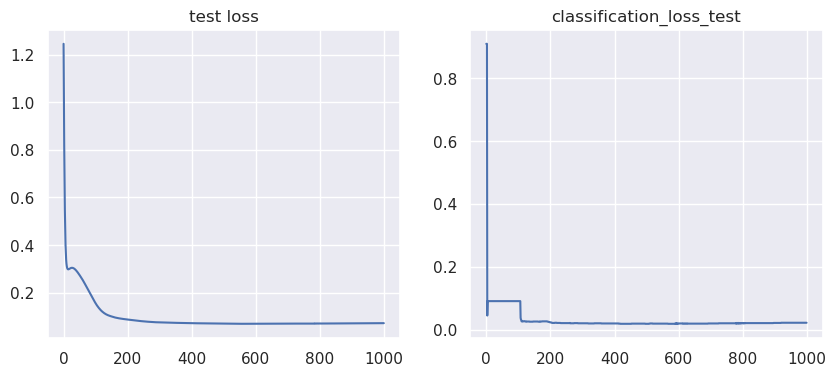

In [35]:
loss_train = []
loss_val = []
loss_test = []

classification_loss_train = []
classification_loss_val = []
classification_loss_test = []

for i in range(epochs):
    tr = train(mynet, train_dataloader, loss, optim)
    vld = validation(mynet, val_dataloader, loss, optim)
    tst = validation(mynet, test_dataloader, loss, optim)
    loss_train.append(tr[0])
    loss_val.append(vld[0])
    loss_test.append(tst[0])
    classification_loss_train.append(tr[1])
    classification_loss_val.append(vld[1])
    classification_loss_test.append(tst[1])
    
    if (i + 1) % 10 == 0:
        clear_output(True)
        fig, ax = plt.subplots(1, 2)
        fig.set_figheight(4)
        fig.set_figwidth(10)
        ax[0].set_title('test loss')
        ax[0].plot(loss_test)
        ax[1].set_title('classification_loss_test')
        ax[1].plot(classification_loss_test)
        plt.show()

In [36]:
PATH = './model'

In [37]:
torch.save(mynet.state_dict(), PATH)

In [38]:
for_init_model = MyNet(6, 10)
torch.save(for_init_model.state_dict(), './init_weights')

# GD

In [79]:
LR = np.array([10, 1, .1, 1e-2, 1e-3])
epochs = 1001

In [110]:
for_each_lr_loss_tst = []
for_each_lr_classification_loss_tst = []
for_each_lr_loss_train = []
for_each_lr_classification_loss_train = []

losses_GD_train = np.empty((len(LR), epochs))
losses_GD_test = np.empty((len(LR), epochs))
losses_GD_val = np.empty((len(LR), epochs))

for i, lr in tqdm(enumerate(LR), total=len(LR)):  
    loss = nn.BCELoss()
    model = MyNet(6, 10).to(device)
    model.load_state_dict(torch.load('./init_weights'))
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs), leave=False):
        tr = train(model, train_dataloader, loss, optim)
        val = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)

        losses_GD_train[i][epoch] = tr[0]
        losses_GD_val[i][epoch] = val[0]
        losses_GD_test[i][epoch] = tst[0]
        
        if epoch % 100 == 0:
            print(f"loss with lr = {lr} on the {epoch}'s epoch is {tst[0]}")
            
    for_each_lr_loss_tst.append(tst[0])
    for_each_lr_classification_loss_tst.append(tst[1])
    for_each_lr_loss_train.append(tr[0])
    for_each_lr_classification_loss_train.append(tr[1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss with lr = 10.0 on the 0's epoch is 1.4088455438613892
loss with lr = 10.0 on the 100's epoch is 0.08385825157165527
loss with lr = 10.0 on the 200's epoch is 0.07889748364686966
loss with lr = 10.0 on the 300's epoch is 0.07513952255249023
loss with lr = 10.0 on the 400's epoch is 0.07242060452699661
loss with lr = 10.0 on the 500's epoch is 0.06977403163909912
loss with lr = 10.0 on the 600's epoch is 0.06771387159824371
loss with lr = 10.0 on the 700's epoch is 0.06598690152168274
loss with lr = 10.0 on the 800's epoch is 0.0647352933883667
loss with lr = 10.0 on the 900's epoch is 0.06381899863481522


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with lr = 1.0 on the 0's epoch is 0.3658687174320221
loss with lr = 1.0 on the 100's epoch is 0.2811596095561981
loss with lr = 1.0 on the 200's epoch is 0.13134141266345978
loss with lr = 1.0 on the 300's epoch is 0.08982032537460327
loss with lr = 1.0 on the 400's epoch is 0.08471067249774933
loss with lr = 1.0 on the 500's epoch is 0.08321653306484222
loss with lr = 1.0 on the 600's epoch is 0.08226495236158371
loss with lr = 1.0 on the 700's epoch is 0.08140045404434204
loss with lr = 1.0 on the 800's epoch is 0.08055666834115982
loss with lr = 1.0 on the 900's epoch is 0.07973414659500122


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with lr = 0.1 on the 0's epoch is 0.8936949968338013
loss with lr = 0.1 on the 100's epoch is 0.30161264538764954
loss with lr = 0.1 on the 200's epoch is 0.29980555176734924
loss with lr = 0.1 on the 300's epoch is 0.2983255088329315
loss with lr = 0.1 on the 400's epoch is 0.2968163788318634
loss with lr = 0.1 on the 500's epoch is 0.2951864004135132
loss with lr = 0.1 on the 600's epoch is 0.2933347523212433
loss with lr = 0.1 on the 700's epoch is 0.29113349318504333
loss with lr = 0.1 on the 800's epoch is 0.2884107232093811
loss with lr = 0.1 on the 900's epoch is 0.2849292457103729


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with lr = 0.01 on the 0's epoch is 0.9847112894058228
loss with lr = 0.01 on the 100's epoch is 0.4719482660293579
loss with lr = 0.01 on the 200's epoch is 0.3596785366535187
loss with lr = 0.01 on the 300's epoch is 0.3257998526096344
loss with lr = 0.01 on the 400's epoch is 0.3130131661891937
loss with lr = 0.01 on the 500's epoch is 0.3074535131454468
loss with lr = 0.01 on the 600's epoch is 0.3047735393047333
loss with lr = 0.01 on the 700's epoch is 0.30336061120033264
loss with lr = 0.01 on the 800's epoch is 0.3025456666946411
loss with lr = 0.01 on the 900's epoch is 0.30202871561050415


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with lr = 0.001 on the 0's epoch is 0.994192898273468
loss with lr = 0.001 on the 100's epoch is 0.8965703248977661
loss with lr = 0.001 on the 200's epoch is 0.813667356967926
loss with lr = 0.001 on the 300's epoch is 0.7434391379356384
loss with lr = 0.001 on the 400's epoch is 0.6839995384216309
loss with lr = 0.001 on the 500's epoch is 0.6336667537689209
loss with lr = 0.001 on the 600's epoch is 0.5909793972969055
loss with lr = 0.001 on the 700's epoch is 0.5546908378601074
loss with lr = 0.001 on the 800's epoch is 0.5237512588500977
loss with lr = 0.001 on the 900's epoch is 0.4972846508026123


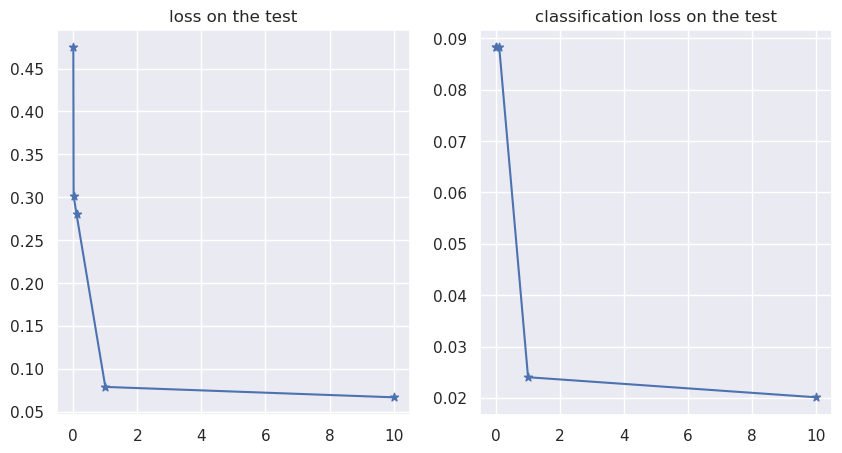

In [112]:
figure, axis = plt.subplots(1, 2, sharex=True, figsize=(10,5))
axis[0].set_title('loss on the test')
axis[1].set_title('classification loss on the test')
axis[0].plot(LR, for_each_lr_loss_tst)
axis[1].plot(LR, for_each_lr_classification_loss_tst);
axis[0].scatter(LR, for_each_lr_loss_tst, marker='*')
axis[1].scatter(LR, for_each_lr_classification_loss_tst, marker='*')

In [127]:
GD_loss_dict_train = {lr:loss for lr, loss in zip(LR, for_each_lr_loss_train)}
GD_loss_dict_train

{10.0: 0.0719839408993721,
 1.0: 0.08215974271297455,
 0.1: 0.28847846388816833,
 0.01: 0.3107144236564636,
 0.001: 0.4776422381401062}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


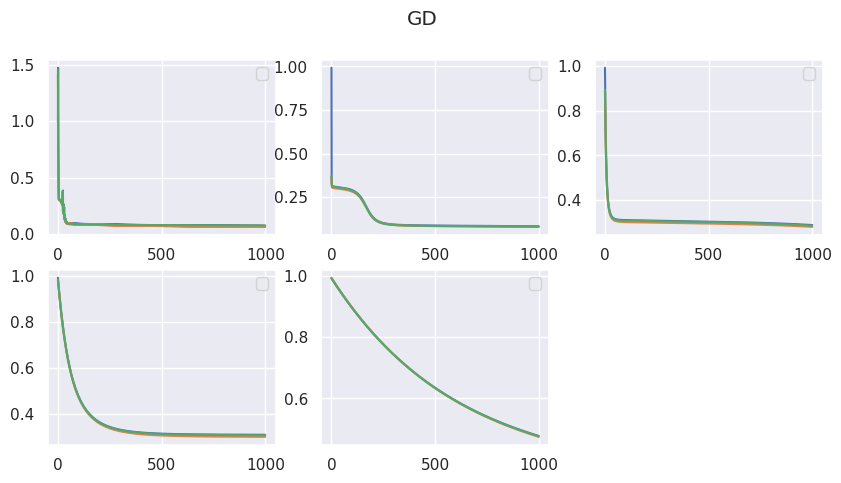

In [188]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle('GD')
for counter in range(len(LR)):
        ax[counter // 3][counter % 3].plot(losses_GD_train[counter])
        ax[counter // 3][counter % 3].plot(losses_GD_test[counter])
        ax[counter // 3][counter % 3].plot(losses_GD_val[counter])
        ax[counter // 3][counter % 3].legend()
ax[-1][-1].remove()

# GD with Momentum

In [170]:
lr = 1
epochs = 1000
MOMENTUM = np.array([0, 0.1, 0.9, 0.999]) 

In [160]:
for_each_momentum_loss_tst = []
for_each_momentum_classification_loss_tst = []
for_each_momentum_loss_train = []
for_each_momentum_classification_loss_train = []

losses_GDM_train = np.empty((len(MOMENTUM), epochs))
losses_GDM_test = np.empty((len(MOMENTUM), epochs))
losses_GDM_val = np.empty((len(MOMENTUM), epochs))

for i, momentum in tqdm(enumerate(MOMENTUM), total=len(MOMENTUM)):
  
    loss = nn.BCELoss()
    model = MyNet(6, 10).to(device)
    model.load_state_dict(torch.load('./init_weights'))
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for epoch in tqdm(range(epochs), leave=False):
        tr = train(model, train_dataloader, loss, optim)
        val = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)
        
        losses_GDM_train[i][epoch] = tr[0]
        losses_GDM_val[i][epoch] = val[0]
        losses_GDM_test[i][epoch] = tst[0]        
        
        if epoch % 100 == 0:
            print(f"loss with momentum = {momentum} on the {epoch}'s epoch is {tst[0]}")

    for_each_momentum_loss_tst.append(tst[0])   
    for_each_momentum_classification_loss_tst.append(tst[1])
    for_each_momentum_loss_train.append(tr[0])
    for_each_momentum_classification_loss_train.append(tr[1])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss with momentum = 0.0 on the 0's epoch is 0.3658687174320221
loss with momentum = 0.0 on the 100's epoch is 0.2811596095561981
loss with momentum = 0.0 on the 200's epoch is 0.13134141266345978
loss with momentum = 0.0 on the 300's epoch is 0.08982032537460327
loss with momentum = 0.0 on the 400's epoch is 0.08471067249774933
loss with momentum = 0.0 on the 500's epoch is 0.08321653306484222
loss with momentum = 0.0 on the 600's epoch is 0.08226495236158371
loss with momentum = 0.0 on the 700's epoch is 0.08140045404434204
loss with momentum = 0.0 on the 800's epoch is 0.08055666834115982
loss with momentum = 0.0 on the 900's epoch is 0.07973414659500122


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with momentum = 0.1 on the 0's epoch is 0.3658687174320221
loss with momentum = 0.1 on the 100's epoch is 0.2753586769104004
loss with momentum = 0.1 on the 200's epoch is 0.11189217120409012
loss with momentum = 0.1 on the 300's epoch is 0.08728804439306259
loss with momentum = 0.1 on the 400's epoch is 0.08392110466957092
loss with momentum = 0.1 on the 500's epoch is 0.08268045634031296
loss with momentum = 0.1 on the 600's epoch is 0.08169973641633987
loss with momentum = 0.1 on the 700's epoch is 0.08075866103172302
loss with momentum = 0.1 on the 800's epoch is 0.07983984798192978
loss with momentum = 0.1 on the 900's epoch is 0.0789361521601677


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with momentum = 0.9 on the 0's epoch is 0.3658687174320221
loss with momentum = 0.9 on the 100's epoch is 0.08717624843120575
loss with momentum = 0.9 on the 200's epoch is 0.07955914735794067
loss with momentum = 0.9 on the 300's epoch is 0.07357674837112427
loss with momentum = 0.9 on the 400's epoch is 0.06750169396400452
loss with momentum = 0.9 on the 500's epoch is 0.06481235474348068
loss with momentum = 0.9 on the 600's epoch is 0.06388812512159348
loss with momentum = 0.9 on the 700's epoch is 0.06320071220397949
loss with momentum = 0.9 on the 800's epoch is 0.06243344768881798
loss with momentum = 0.9 on the 900's epoch is 0.06184517592191696


  0%|          | 0/1000 [00:00<?, ?it/s]

loss with momentum = 0.999 on the 0's epoch is 0.3658687174320221
loss with momentum = 0.999 on the 100's epoch is 0.3049981892108917
loss with momentum = 0.999 on the 200's epoch is 0.3030896782875061
loss with momentum = 0.999 on the 300's epoch is 0.3089780807495117
loss with momentum = 0.999 on the 400's epoch is 0.3053430914878845
loss with momentum = 0.999 on the 500's epoch is 0.31935665011405945
loss with momentum = 0.999 on the 600's epoch is 0.31586742401123047
loss with momentum = 0.999 on the 700's epoch is 0.31764331459999084
loss with momentum = 0.999 on the 800's epoch is 0.3125511109828949
loss with momentum = 0.999 on the 900's epoch is 0.31090235710144043


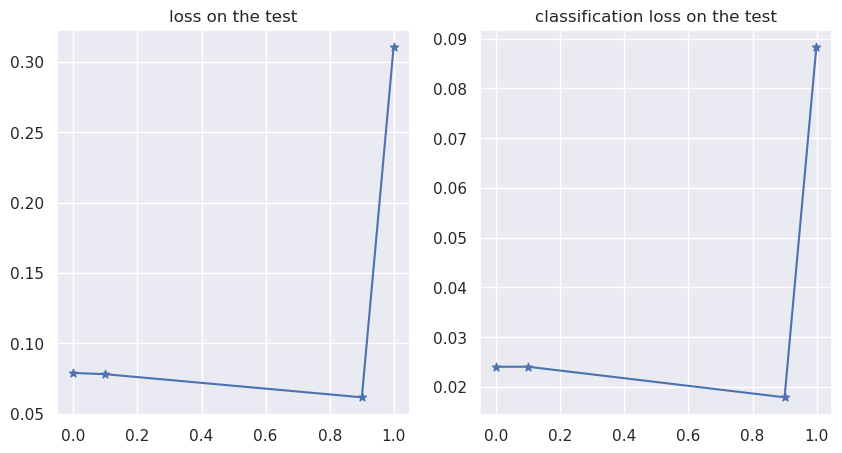

In [147]:
figure, axis = plt.subplots(1, 2, sharex=True, figsize=(10,5))
axis[0].set_title('loss on the test')
axis[1].set_title('classification loss on the test')
axis[0].plot(MOMENTUM, for_each_momentum_loss_tst)
axis[1].plot(MOMENTUM, for_each_momentum_classification_loss_tst);
axis[0].scatter(MOMENTUM, for_each_momentum_loss_tst, marker='*')
axis[1].scatter(MOMENTUM, for_each_momentum_classification_loss_tst, marker='*')

In [148]:
GDM_loss_dict_train = {momentum: loss for momentum, loss in zip(MOMENTUM,for_each_momentum_loss_train)}
GDM_loss_dict_train

{0.0: 0.08215974271297455,
 0.1: 0.08135758340358734,
 0.9: 0.0672072172164917,
 0.999: 0.32469919323921204}

In [149]:
GDM_loss_dict_tst = {momentum: loss for momentum, loss in zip(MOMENTUM,for_each_momentum_loss_tst)}
GDM_loss_dict_tst

{0.0: 0.07892993092536926,
 0.1: 0.0780196338891983,
 0.9: 0.06160445511341095,
 0.999: 0.31029412150382996}

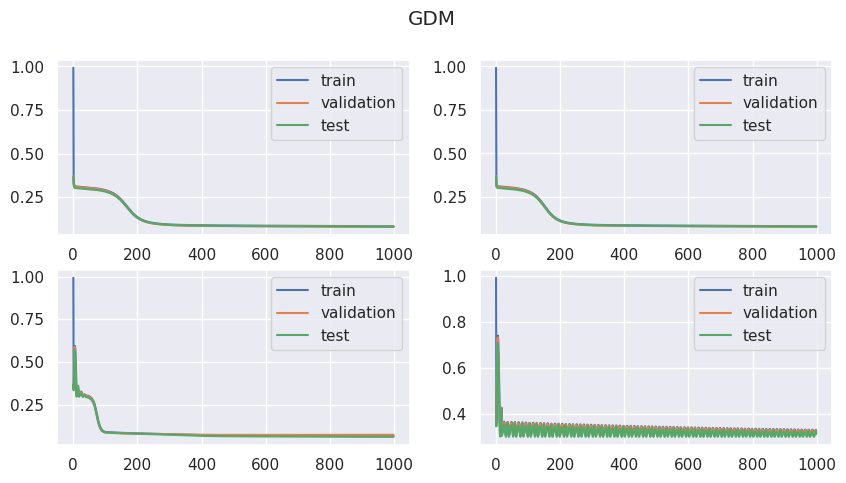

In [169]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle('GDM')
for counter in range(len(MOMENTUM)):
        ax[counter // 2][counter % 2].plot(losses_GDM_train[counter], label='train')
        ax[counter // 2][counter % 2].plot(losses_GDM_val[counter], label='validation')
        ax[counter // 2][counter % 2].plot(losses_GDM_test[counter], label='test')
        ax[counter // 2][counter % 2].legend()


# NAG

In [174]:
lr = 1e-2
epochs = 1001
MOMENTUM = np.array([0.01, 0.9, 0.99, 0.999]) 

In [177]:
for_each_momentum_loss_tst = []
for_each_momentum_classification_loss_tst = []
for_each_momentum_loss_train = []
for_each_momentum_classification_loss_train = []

losses_NAG_train = np.empty((len(MOMENTUM), epochs))
losses_NAG_test = np.empty((len(MOMENTUM), epochs))
losses_NAG_val = np.empty((len(MOMENTUM), epochs))

for i, momentum in tqdm(enumerate(MOMENTUM), total=len(MOMENTUM)):
  
    loss = nn.BCELoss()
    model = MyNet(6, 10).to(device)
    model.load_state_dict(torch.load('./init_weights'))
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    for epoch in tqdm(range(epochs), leave=False):
        tr = train(model, train_dataloader, loss, optim)
        val = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)

        losses_NAG_train[i][epoch] = tr[0]
        losses_NAG_val[i][epoch] = val[0]
        losses_NAG_test[i][epoch] = tst[0] 
        
        if epoch % 100 == 0:
            print(f"loss with momentum = {momentum} on the {epoch}'s epoch is {tst[0]}")

    for_each_momentum_NAG_loss_tst.append(tst[0])
    for_each_momentum_NAG_classification_loss_tst.append(tst[1])
    for_each_momentum_NAG_loss_train.append(tr[0])
    for_each_momentum_NAG_classification_loss_train.append(tr[1])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

loss with momentum = 0.01 on the 0's epoch is 0.9846062660217285
loss with momentum = 0.01 on the 100's epoch is 0.4698408544063568
loss with momentum = 0.01 on the 200's epoch is 0.3585579991340637
loss with momentum = 0.01 on the 300's epoch is 0.32521432638168335
loss with momentum = 0.01 on the 400's epoch is 0.31269195675849915
loss with momentum = 0.01 on the 500's epoch is 0.30726826190948486
loss with momentum = 0.01 on the 600's epoch is 0.3046610355377197
loss with momentum = 0.01 on the 700's epoch is 0.3032880425453186
loss with momentum = 0.01 on the 800's epoch is 0.3024953007698059
loss with momentum = 0.01 on the 900's epoch is 0.3019907474517822
loss with momentum = 0.01 on the 1000's epoch is 0.30163609981536865


  0%|          | 0/1001 [00:00<?, ?it/s]

loss with momentum = 0.9 on the 0's epoch is 0.9752979874610901
loss with momentum = 0.9 on the 100's epoch is 0.30137279629707336
loss with momentum = 0.9 on the 200's epoch is 0.2999570369720459
loss with momentum = 0.9 on the 300's epoch is 0.29853183031082153
loss with momentum = 0.9 on the 400's epoch is 0.2970883846282959
loss with momentum = 0.9 on the 500's epoch is 0.29554757475852966
loss with momentum = 0.9 on the 600's epoch is 0.2938198149204254
loss with momentum = 0.9 on the 700's epoch is 0.2917945384979248
loss with momentum = 0.9 on the 800's epoch is 0.28932708501815796
loss with momentum = 0.9 on the 900's epoch is 0.28622138500213623
loss with momentum = 0.9 on the 1000's epoch is 0.2822083532810211


  0%|          | 0/1001 [00:00<?, ?it/s]

loss with momentum = 0.99 on the 0's epoch is 0.9743603467941284
loss with momentum = 0.99 on the 100's epoch is 0.32512444257736206
loss with momentum = 0.99 on the 200's epoch is 0.295768141746521
loss with momentum = 0.99 on the 300's epoch is 0.29057419300079346
loss with momentum = 0.99 on the 400's epoch is 0.28128868341445923
loss with momentum = 0.99 on the 500's epoch is 0.25021111965179443
loss with momentum = 0.99 on the 600's epoch is 0.1736941933631897
loss with momentum = 0.99 on the 700's epoch is 0.11138837039470673
loss with momentum = 0.99 on the 800's epoch is 0.09107261151075363
loss with momentum = 0.99 on the 900's epoch is 0.08641817420721054
loss with momentum = 0.99 on the 1000's epoch is 0.08502642065286636


  0%|          | 0/1001 [00:00<?, ?it/s]

loss with momentum = 0.999 on the 0's epoch is 0.9742667078971863
loss with momentum = 0.999 on the 100's epoch is 0.41658103466033936
loss with momentum = 0.999 on the 200's epoch is 0.30136582255363464
loss with momentum = 0.999 on the 300's epoch is 0.3162996470928192
loss with momentum = 0.999 on the 400's epoch is 0.3143198490142822
loss with momentum = 0.999 on the 500's epoch is 0.3264652490615845
loss with momentum = 0.999 on the 600's epoch is 0.33094364404678345
loss with momentum = 0.999 on the 700's epoch is 0.31904706358909607
loss with momentum = 0.999 on the 800's epoch is 0.31392455101013184
loss with momentum = 0.999 on the 900's epoch is 0.3063437044620514
loss with momentum = 0.999 on the 1000's epoch is 0.3005398213863373


In [180]:
NAG_loss_dict_train = {momentum: loss for momentum, loss in zip(MOMENTUM,for_each_momentum_NAG_loss_train)}
NAG_loss_dict_train

{0.01: 0.08434803098906656,
 0.9: 0.0768674996117961,
 0.99: 0.10988056385677367,
 0.999: 9.22804730421827}

In [181]:
NAG_loss_dict_tst = {momentum: loss for momentum, loss in zip(MOMENTUM,for_each_momentum_NAG_loss_tst)}
NAG_loss_dict_tst

{0.01: 0.07970007599771085,
 0.9: 0.06453176522952656,
 0.99: 0.15310958813722245,
 0.999: 8.8268156424581}

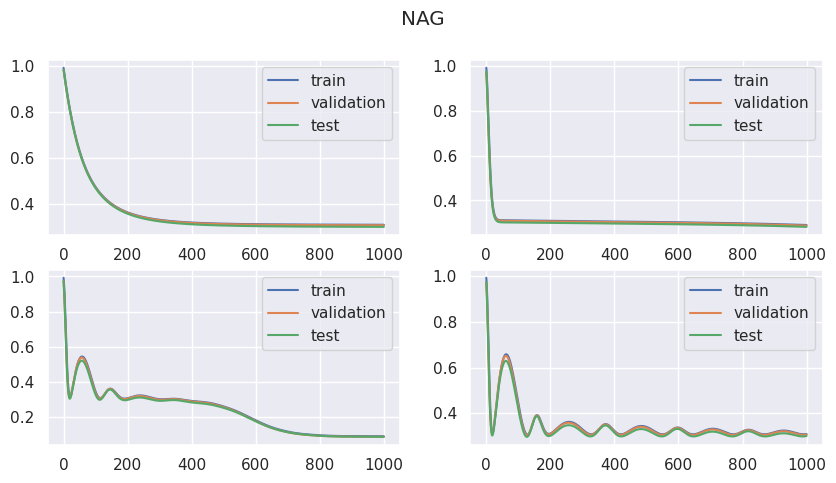

In [183]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle('NAG')
for counter in range(len(MOMENTUM)):
        ax[counter // 2][counter % 2].plot(losses_NAG_train[counter], label='train')
        ax[counter // 2][counter % 2].plot(losses_NAG_val[counter], label='validation')
        ax[counter // 2][counter % 2].plot(losses_NAG_test[counter], label='test')
        ax[counter // 2][counter % 2].legend()


# SGD

In [39]:
lr = 0.1
epochs = 500

In [40]:
train_SGD_data = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
train_SGD_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)

val_SGD_data = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
val_SGD_dataloader = DataLoader(val_data, batch_size=100)

test_SGD_data = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))
test_SGD_dataloader = DataLoader(test_data, batch_size=100)

In [41]:
loss = nn.BCELoss()
model = MyNet(6, 10).to(device)
model.load_state_dict(torch.load('./init_weights'))
optim = torch.optim.SGD(model.parameters(), lr=lr)

In [42]:
loss_SGD_train = []
loss_SGD_val = []
loss_SGD_test = []
classification_loss_SGD_train = []
classification_loss_SGD_val = []
classification_loss_SGD_test = []


for epoch in tqdm(range(epochs)):
    
    tr = train(model, train_SGD_dataloader, loss, optim)
    vld = validation(model, val_SGD_dataloader, loss, optim)
    tst = validation(model, test_SGD_dataloader, loss, optim)
    loss_SGD_train.append(tr[0])
    loss_SGD_val.append(vld[0])
    loss_SGD_test.append(tst[0])
    classification_loss_SGD_train.append(tr[1])
    classification_loss_SGD_val.append(vld[1])
    classification_loss_SGD_test.append(tst[1])
    
    if epoch % 50 == 0:
        print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/500 [00:00<?, ?it/s]

loss on the 0's epoch is 0.30521778265635174
loss on the 50's epoch is 0.08866563584241602
loss on the 100's epoch is 0.08431164092487758
loss on the 150's epoch is 0.08034826494339439
loss on the 200's epoch is 0.07686400744650099
loss on the 250's epoch is 0.07429219751308362
loss on the 300's epoch is 0.07294025147954623
loss on the 350's epoch is 0.07196396816935804
loss on the 400's epoch is 0.07175207282933924
loss on the 450's epoch is 0.07127214626719554


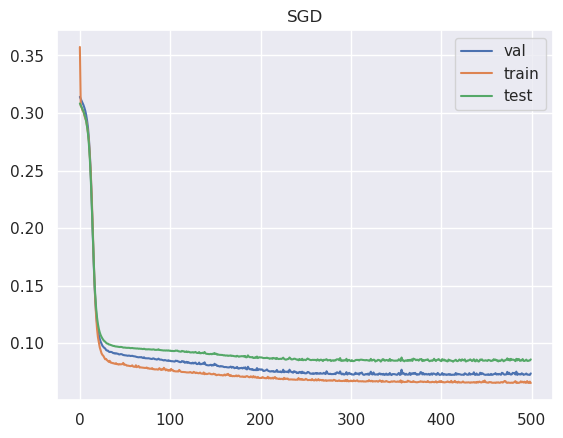

In [133]:
plt.plot(loss_SGD_val, label='val')
plt.plot(loss_SGD_train, label='train')
plt.plot(loss_SGD_test, label='test')
plt.legend()
plt.title('SGD');

In [134]:
print(loss_SGD_train[-1], loss_SGD_test[-1])

0.06557592419321062 0.08606926082736915


# AdaGrad

In [268]:
lr = 1
epochs = 1000
model = MyNet(6, 10).to(device)

In [269]:
loss = nn.BCELoss()
optim = torch.optim.Adagrad(model.parameters(), lr=lr)

In [270]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [271]:
loss_Adagrad_train = []
loss_Adagrad_val = []
loss_Adagrad_test = []
classification_loss_Adagrad_train = []
classification_loss_Adagrad_val = []
classification_loss_Adagrad_test = []

max_lst = []
min_lst = []
avg_lst = []

first_lst = []
second_lst = []
third_lst = []
fourth_lst = []

for epoch in tqdm(range(epochs)):
    tr = train(model, train_dataloader, loss, optim)
    vld = validation(model, val_dataloader, loss, optim)
    tst = validation(model, test_dataloader, loss, optim)
    loss_Adagrad_train.append(tr[0])
    loss_Adagrad_val.append(vld[0])
    loss_Adagrad_test.append(tst[0])
    classification_loss_Adagrad_train.append(tr[1])
    classification_loss_Adagrad_val.append(vld[1])
    classification_loss_Adagrad_test.append(tst[1])
    max_value_in_sum = float("-INF")
    min_value_in_sum = float("INF")
    sum_of_all_tensors = 0
    count_of_all_numbers = 0
    
    
    for i in optim.state.items():    
        min_value_in_sum = min(min_value_in_sum, i[1]['sum'].min())
        max_value_in_sum = max(max_value_in_sum, i[1]['sum'].max())
        sum_of_all_tensors += i[1]['sum'].sum()
        count_of_all_numbers += i[1]['sum'].numel()
    avg_of_all_tensors = sum_of_all_tensors / count_of_all_numbers
    
    min_lst.append(min_value_in_sum.cpu().item())
    max_lst.append(max_value_in_sum.cpu().item())
    avg_lst.append(avg_of_all_tensors.cpu().item())
    
    first_lst.append(model.linear1.weight[first].cpu().item())
    second_lst.append(model.linear2.weight[second].cpu().item())
    third_lst.append(model.linear3.weight[third].cpu().item())
    fourth_lst.append(model.linear4.weight[fourth].cpu().item())
    
    if epoch % 100 == 0:
        print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.5997934341430664
loss on the 100's epoch is 0.10455702245235443
loss on the 200's epoch is 0.09183207899332047
loss on the 300's epoch is 0.08881356567144394
loss on the 400's epoch is 0.08763480186462402
loss on the 500's epoch is 0.0870160162448883
loss on the 600's epoch is 0.0870741680264473
loss on the 700's epoch is 0.08682180941104889
loss on the 800's epoch is 0.08673270791769028
loss on the 900's epoch is 0.08668448030948639


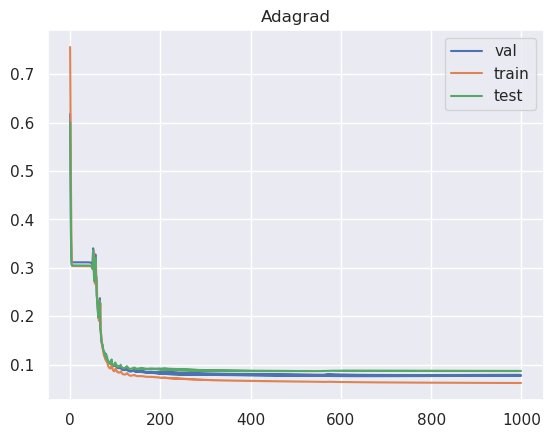

In [274]:
plt.plot(loss_Adagrad_val, label='val')
plt.plot(loss_Adagrad_train, label='train')
plt.plot(loss_Adagrad_test, label='test')
plt.legend()
plt.title('Adagrad');

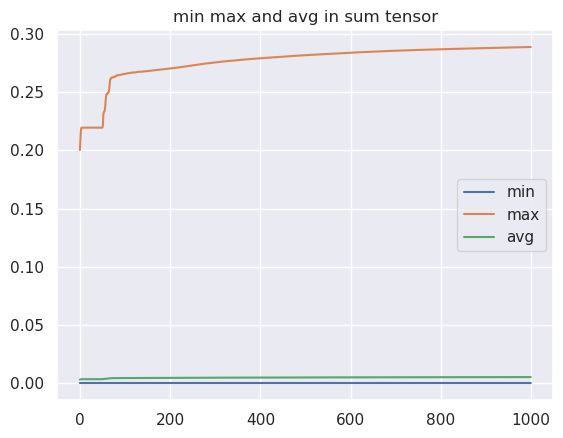

In [280]:
plt.plot(min_lst, label='min')
plt.plot(max_lst, label='max')
plt.plot(avg_lst, label='avg')
plt.legend()
plt.title('min max and avg in sum tensor');

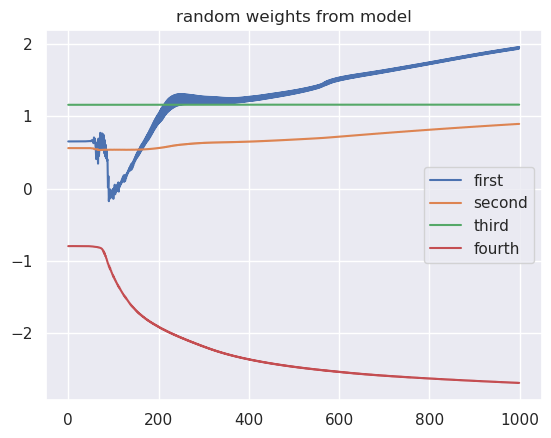

In [279]:
plt.plot(first_lst, label='first')
plt.plot(second_lst, label='second')
plt.plot(third_lst, label='third')
plt.plot(fourth_lst, label='fourth')
plt.legend()
plt.title('random weights from model');

In [281]:
print(loss_Adagrad_train[-1], loss_Adagrad_test[-1])

0.06207096576690674 0.08715248852968216


# RMSProp

In [54]:
lr = 0.1
epochs = 1000

In [55]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [56]:
ALPHAS = np.array([0, 0.01, 0.1, 0.9])

In [57]:
loss_RMSProp_train = np.empty((len(ALPHAS), epochs))
loss_RMSProp_val = np.empty((len(ALPHAS), epochs))
loss_RMSProp_test = np.empty((len(ALPHAS), epochs))
classification_loss_RMSProp_train = np.empty((len(ALPHAS), epochs))
classification_loss_RMSProp_val = np.empty((len(ALPHAS), epochs))
classification_loss_RMSProp_test = np.empty((len(ALPHAS), epochs))

max_lst = np.empty((len(ALPHAS), epochs))
min_lst = np.empty((len(ALPHAS), epochs))
avg_lst = np.empty((len(ALPHAS), epochs))

first_lst = np.empty((len(ALPHAS), epochs))
second_lst = np.empty((len(ALPHAS), epochs))
third_lst = np.empty((len(ALPHAS), epochs))
fourth_lst = np.empty((len(ALPHAS), epochs))

for i, alpha in tqdm(enumerate(ALPHAS), total=len(ALPHAS)):
    
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    optim = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)
    
    for j, epoch in tqdm(enumerate(range(epochs)), total=epochs, leave=False):
        tr = train(model, train_dataloader, loss, optim)
        vld = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)
        loss_RMSProp_train[i][j] = tr[0]
        loss_RMSProp_val[i][j] = vld[0]
        loss_RMSProp_test[i][j] = tst[0]
        classification_loss_RMSProp_train[i][j] = tr[1]
        classification_loss_RMSProp_val[i][j] = vld[1]
        classification_loss_RMSProp_test[i][j] = tst[1]
        max_value_in_sum = float("-INF")
        min_value_in_sum = float("INF")
        
        sum_of_all_tensors = 0
        count_of_all_numbers = 0


        for state in optim.state.items():    
            min_value_in_sum = min(min_value_in_sum, state[1]['square_avg'].min())
            max_value_in_sum = max(max_value_in_sum, state[1]['square_avg'].max())
            sum_of_all_tensors += state[1]['square_avg'].sum()
            count_of_all_numbers += state[1]['square_avg'].numel()
        avg_of_all_tensors = sum_of_all_tensors / count_of_all_numbers
        
        
        min_lst[i][j] = min_value_in_sum.cpu().item()
        max_lst[i][j] = max_value_in_sum.cpu().item()
        avg_lst[i][j] = avg_of_all_tensors.cpu().item()

        first_lst[i][j] = model.linear1.weight[first].cpu().item()
        second_lst[i][j] = model.linear2.weight[second].cpu().item()
        third_lst[i][j] = model.linear3.weight[third].cpu().item()
        fourth_lst[i][j] = model.linear4.weight[fourth].cpu().item()

        if epoch % 100 == 0:
            print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.34831854701042175
loss on the 100's epoch is 0.14957086741924286
loss on the 200's epoch is 0.14946703612804413
loss on the 300's epoch is 0.14936959743499756
loss on the 400's epoch is 0.1492760330438614
loss on the 500's epoch is 0.14918549358844757
loss on the 600's epoch is 0.1490974873304367
loss on the 700's epoch is 0.14901168644428253
loss on the 800's epoch is 0.14892783761024475
loss on the 900's epoch is 0.14884576201438904


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.5199198722839355
loss on the 100's epoch is 0.11753078550100327
loss on the 200's epoch is 0.11561042070388794
loss on the 300's epoch is 0.1145031601190567
loss on the 400's epoch is 0.1135687455534935
loss on the 500's epoch is 0.11271262913942337
loss on the 600's epoch is 0.11192192882299423
loss on the 700's epoch is 0.11113275587558746
loss on the 800's epoch is 0.11033296585083008
loss on the 900's epoch is 0.10938654094934464


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.45157361030578613
loss on the 100's epoch is 0.12330111116170883
loss on the 200's epoch is 0.1130208894610405
loss on the 300's epoch is 0.10731453448534012
loss on the 400's epoch is 0.10547813773155212
loss on the 500's epoch is 0.10497770458459854
loss on the 600's epoch is 0.10436557233333588
loss on the 700's epoch is 0.1035396084189415
loss on the 800's epoch is 0.10263253003358841
loss on the 900's epoch is 0.10166514664888382


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.4031539857387543
loss on the 100's epoch is 0.10272619873285294
loss on the 200's epoch is 0.10000447183847427
loss on the 300's epoch is 0.09950973838567734
loss on the 400's epoch is 0.09990357607603073
loss on the 500's epoch is 0.09940116107463837
loss on the 600's epoch is 0.09890520572662354
loss on the 700's epoch is 0.10337799787521362
loss on the 800's epoch is 0.0999886766076088
loss on the 900's epoch is 0.10253557562828064


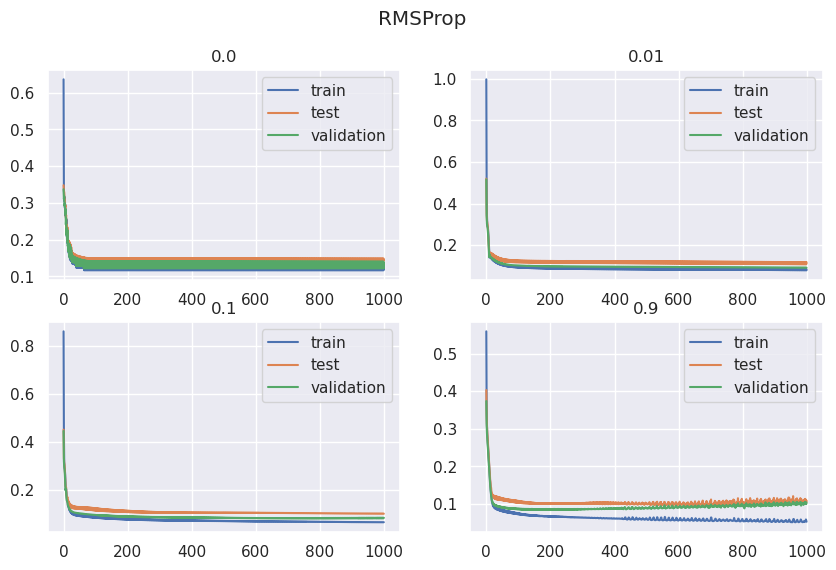

In [66]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('RMSProp')
for counter in range(len(ALPHAS)):
        ax[counter // 2][counter % 2].plot(loss_RMSProp_train[counter], label='train')
        ax[counter // 2][counter % 2].plot(loss_RMSProp_test[counter], label='test')
        ax[counter // 2][counter % 2].plot(loss_RMSProp_val[counter], label='validation')
        ax[counter // 2][counter % 2].legend()
        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')


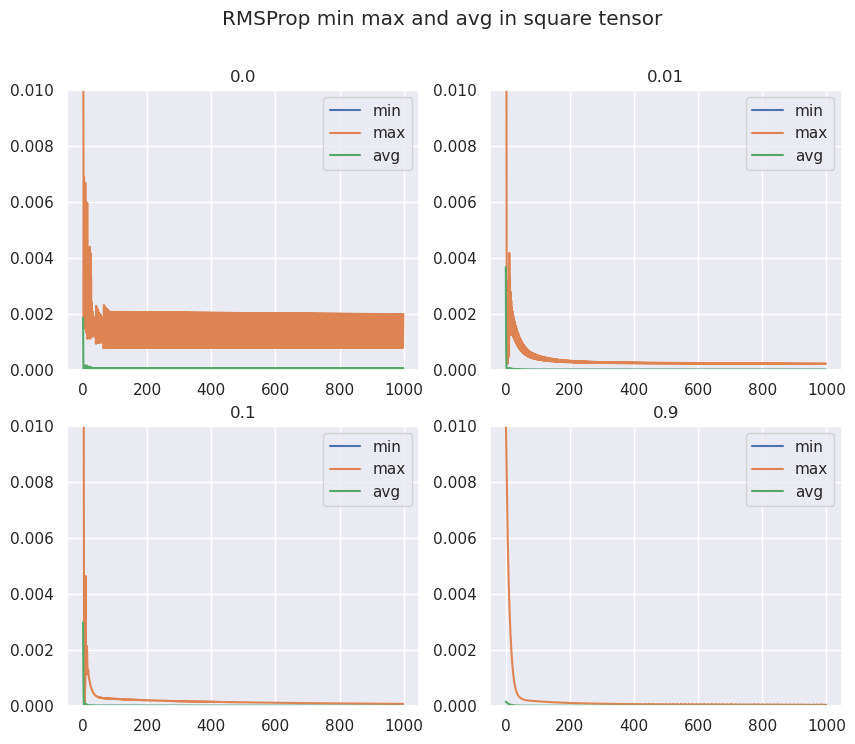

In [76]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle('RMSProp min max and avg in square tensor')
for counter in range(len(ALPHAS)):
        ax[counter // 2][counter % 2].set_ylim([0,0.01])
        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')   
        ax[counter // 2][counter % 2].plot(min_lst[counter], label='min')
        ax[counter // 2][counter % 2].plot(max_lst[counter], label='max')
        ax[counter // 2][counter % 2].plot(avg_lst[counter], label='avg')
        ax[counter // 2][counter % 2].legend()
        

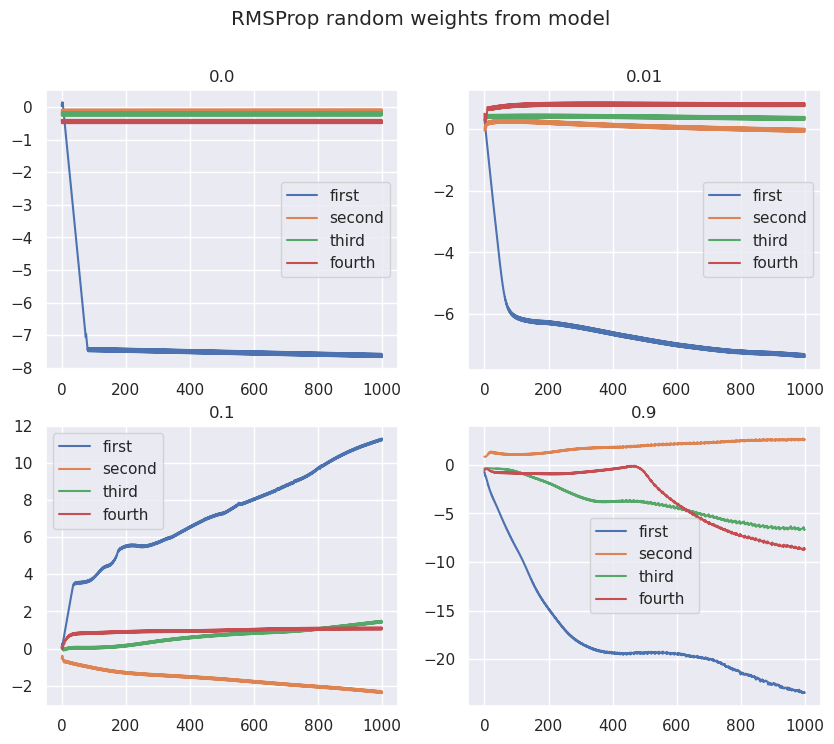

In [77]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle('RMSProp random weights from model')
for counter in range(len(ALPHAS)):

        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')   
        ax[counter // 2][counter % 2].plot(first_lst[counter], label='first')
        ax[counter // 2][counter % 2].plot(second_lst[counter], label='second')
        ax[counter // 2][counter % 2].plot(third_lst[counter], label='third')
        ax[counter // 2][counter % 2].plot(fourth_lst[counter], label='fourth')
        ax[counter // 2][counter % 2].legend()

In [81]:
for i, alp in enumerate(ALPHAS):
    print('train', loss_RMSProp_train[i][-1], 'RMSProp with alpha =', alp)
    print('test', loss_RMSProp_test[i][-1], 'RMSProp with alpha =', alp)

train 0.13247188925743103 RMSProp with alpha = 0.0
test 0.14331133663654327 RMSProp with alpha = 0.0
train 0.07940904051065445 RMSProp with alpha = 0.01
test 0.11796721071004868 RMSProp with alpha = 0.01
train 0.06499182432889938 RMSProp with alpha = 0.1
test 0.10039866715669632 RMSProp with alpha = 0.1
train 0.052446164190769196 RMSProp with alpha = 0.9
test 0.10866910964250565 RMSProp with alpha = 0.9


# Adadelta

In [89]:
lr = 0.1
epochs = 1000

In [83]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [84]:
ALPHAS = np.array([0, 0.01, 0.1, 0.9])

In [97]:
loss_Adadelta_train = np.empty((len(ALPHAS), epochs))
loss_Adadelta_val = np.empty((len(ALPHAS), epochs))
loss_Adadelta_test = np.empty((len(ALPHAS), epochs))
classification_loss_Adadelta_train = np.empty((len(ALPHAS), epochs))
classification_loss_Adadelta_val = np.empty((len(ALPHAS), epochs))
classification_loss_Adadelta_test = np.empty((len(ALPHAS), epochs))

max_lst = np.empty((len(ALPHAS), epochs))
min_lst = np.empty((len(ALPHAS), epochs))
avg_lst = np.empty((len(ALPHAS), epochs))

first_lst = np.empty((len(ALPHAS), epochs))
second_lst = np.empty((len(ALPHAS), epochs))
third_lst = np.empty((len(ALPHAS), epochs))
fourth_lst = np.empty((len(ALPHAS), epochs))

for i, alpha in tqdm(enumerate(ALPHAS), total=len(ALPHAS)):
    
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    optim = torch.optim.Adadelta(model.parameters(), rho=alpha)
    
    for j, epoch in tqdm(enumerate(range(epochs)), total=epochs, leave=False):
        tr = train(model, train_dataloader, loss, optim)
        vld = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)
        loss_Adadelta_train[i][j] = tr[0]
        loss_Adadelta_val[i][j] = vld[0]
        loss_Adadelta_test[i][j] = tst[0]
        classification_loss_Adadelta_train[i][j] = tr[1]
        classification_loss_Adadelta_val[i][j] = vld[1]
        classification_loss_Adadelta_test[i][j] = tst[1]
        max_value_in_sum = float("-INF")
        min_value_in_sum = float("INF")
        
        sum_of_all_tensors = 0
        count_of_all_numbers = 0


        for state in optim.state.items():    
            min_value_in_sum = min(min_value_in_sum, state[1]['square_avg'].min())
            max_value_in_sum = max(max_value_in_sum, state[1]['square_avg'].max())
            sum_of_all_tensors += state[1]['square_avg'].sum()
            count_of_all_numbers += state[1]['square_avg'].numel()
        avg_of_all_tensors = sum_of_all_tensors / count_of_all_numbers
        
        
        min_lst[i][j] = min_value_in_sum.cpu().item()
        max_lst[i][j] = max_value_in_sum.cpu().item()
        avg_lst[i][j] = avg_of_all_tensors.cpu().item()

        first_lst[i][j] = model.linear1.weight[first].cpu().item()
        second_lst[i][j] = model.linear2.weight[second].cpu().item()
        third_lst[i][j] = model.linear3.weight[third].cpu().item()
        fourth_lst[i][j] = model.linear4.weight[fourth].cpu().item()

        if epoch % 100 == 0:
            print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 1.1228339672088623
loss on the 100's epoch is 0.30509084463119507
loss on the 200's epoch is 0.18231913447380066
loss on the 300's epoch is 0.11675818264484406
loss on the 400's epoch is 0.11113467067480087
loss on the 500's epoch is 0.11022970825433731
loss on the 600's epoch is 0.10964124649763107
loss on the 700's epoch is 0.10892371088266373
loss on the 800's epoch is 0.1081852838397026
loss on the 900's epoch is 0.10746532678604126


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.6706503629684448
loss on the 100's epoch is 0.31669384241104126
loss on the 200's epoch is 0.2822627127170563
loss on the 300's epoch is 0.15299773216247559
loss on the 400's epoch is 0.11241944134235382
loss on the 500's epoch is 0.10873456299304962
loss on the 600's epoch is 0.10826507210731506
loss on the 700's epoch is 0.10783522576093674
loss on the 800's epoch is 0.10727565735578537
loss on the 900's epoch is 0.10668019205331802


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.8715531826019287
loss on the 100's epoch is 0.32145002484321594
loss on the 200's epoch is 0.28728991746902466
loss on the 300's epoch is 0.14642451703548431
loss on the 400's epoch is 0.11140180379152298
loss on the 500's epoch is 0.10930810868740082
loss on the 600's epoch is 0.10879360884428024
loss on the 700's epoch is 0.10816684365272522
loss on the 800's epoch is 0.10744016617536545
loss on the 900's epoch is 0.10666623711585999


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 1.2323063611984253
loss on the 100's epoch is 0.34150612354278564
loss on the 200's epoch is 0.31112298369407654
loss on the 300's epoch is 0.24446721374988556
loss on the 400's epoch is 0.12522360682487488
loss on the 500's epoch is 0.11179308593273163
loss on the 600's epoch is 0.10977303236722946
loss on the 700's epoch is 0.10909445583820343
loss on the 800's epoch is 0.10834615677595139
loss on the 900's epoch is 0.10750902444124222


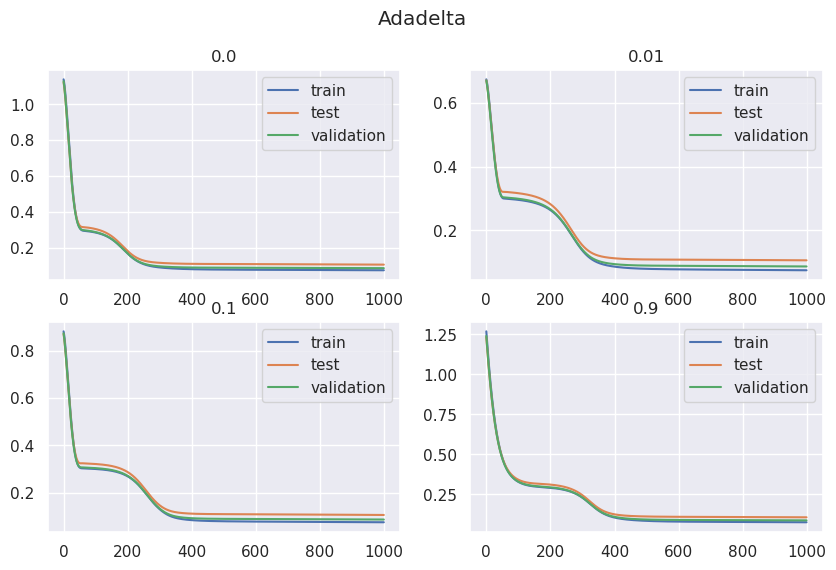

In [104]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Adadelta')
for counter in range(len(ALPHAS)):
        ax[counter // 2][counter % 2].plot(loss_Adadelta_train[counter], label='train')
        ax[counter // 2][counter % 2].plot(loss_Adadelta_test[counter], label='test')
        ax[counter // 2][counter % 2].plot(loss_Adadelta_val[counter], label='validation')
        ax[counter // 2][counter % 2].legend()
        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')


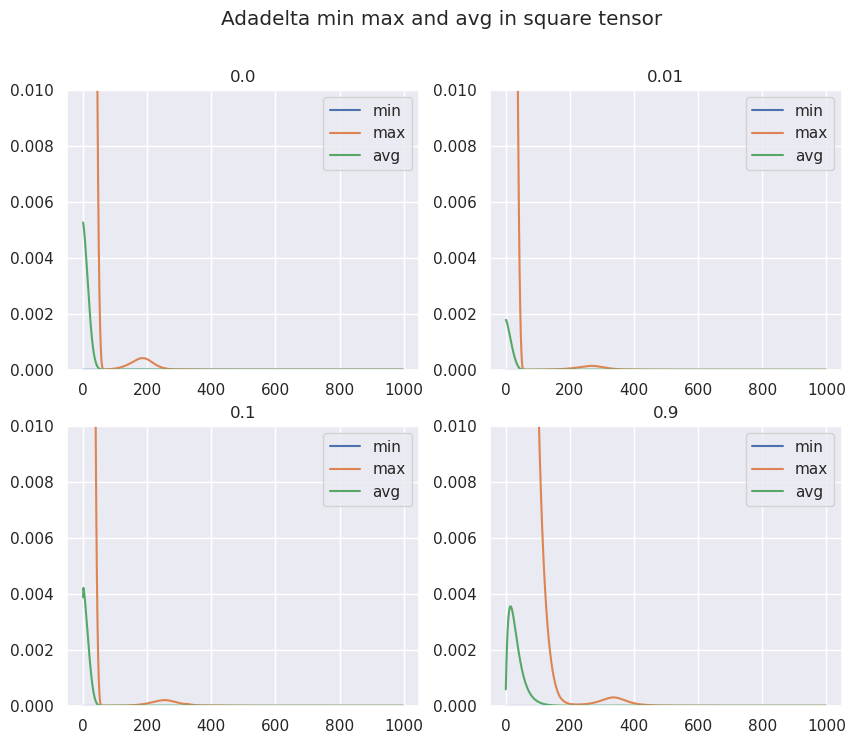

In [105]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle('Adadelta min max and avg in square tensor')
for counter in range(len(ALPHAS)):
        ax[counter // 2][counter % 2].set_ylim([0,0.01])
        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')   
        ax[counter // 2][counter % 2].plot(min_lst[counter], label='min')
        ax[counter // 2][counter % 2].plot(max_lst[counter], label='max')
        ax[counter // 2][counter % 2].plot(avg_lst[counter], label='avg')
        ax[counter // 2][counter % 2].legend()
        

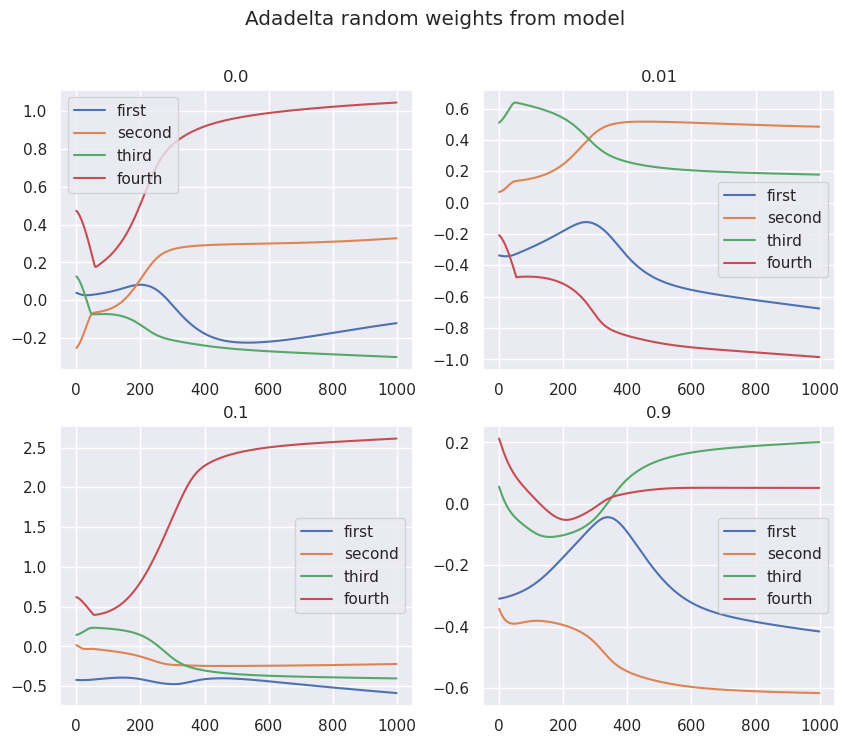

In [106]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle('Adadelta random weights from model')
for counter in range(len(ALPHAS)):

        ax[counter // 2][counter % 2].set_title(f'{ALPHAS[counter]}')   
        ax[counter // 2][counter % 2].plot(first_lst[counter], label='first')
        ax[counter // 2][counter % 2].plot(second_lst[counter], label='second')
        ax[counter // 2][counter % 2].plot(third_lst[counter], label='third')
        ax[counter // 2][counter % 2].plot(fourth_lst[counter], label='fourth')
        ax[counter // 2][counter % 2].legend()

In [109]:
for i, alp in enumerate(ALPHAS):
    print('train', loss_Adadelta_train[i][-1], 'Adadelta with alpha =', alp)
    print('test', loss_Adadelta_test[i][-1], 'Adadelta with alpha =', alp)

train 0.07538601011037827 Adadelta with alpha = 0.0
test 0.10676971077919006 Adadelta with alpha = 0.0
train 0.07489138096570969 Adadelta with alpha = 0.01
test 0.10609665513038635 Adadelta with alpha = 0.01
train 0.07502277195453644 Adadelta with alpha = 0.1
test 0.10587729513645172 Adadelta with alpha = 0.1
train 0.07572189718484879 Adadelta with alpha = 0.9
test 0.10669297724962234 Adadelta with alpha = 0.9


# Adam

In [139]:
lr = 0.1
epochs = 1000

In [140]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [141]:
BETAS = [(0.8, 0.999), (0.9, 0.999), (0.95, 0.999), (0.9, 0.99), (0.9, 0.9), (0.9, 0.8)]


In [143]:
loss_Adam_train = np.empty((len(BETAS), epochs))
loss_Adam_val = np.empty((len(BETAS), epochs))
loss_Adam_test = np.empty((len(BETAS), epochs))
classification_loss_Adam_train = np.empty((len(BETAS), epochs))
classification_loss_Adam_val = np.empty((len(BETAS), epochs))
classification_loss_Adam_test = np.empty((len(BETAS), epochs))

max_lst = np.empty((len(BETAS), epochs))
min_lst = np.empty((len(BETAS), epochs))
avg_lst = np.empty((len(BETAS), epochs))

first_lst = np.empty((len(BETAS), epochs))
second_lst = np.empty((len(BETAS), epochs))
third_lst = np.empty((len(BETAS), epochs))
fourth_lst = np.empty((len(BETAS), epochs))

for i, betas in tqdm(enumerate(BETAS), total=len(BETAS)):
    
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    
    for j, epoch in tqdm(enumerate(range(epochs)), total=epochs, leave=False):
        tr = train(model, train_dataloader, loss, optim)
        vld = validation(model, val_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)
        loss_Adam_train[i][j] = tr[0]
        loss_Adam_val[i][j] = vld[0]
        loss_Adam_test[i][j] = tst[0]
        classification_loss_Adam_train[i][j] = tr[1]
        classification_loss_Adam_val[i][j] = vld[1]
        classification_loss_Adam_test[i][j] = tst[1]
        max_value_in_sum = float("-INF")
        min_value_in_sum = float("INF")
        
        sum_of_all_tensors = 0
        count_of_all_numbers = 0


        for state in optim.state.items():    
            min_value_in_sum = min(min_value_in_sum, state[1]['exp_avg'].min())
            max_value_in_sum = max(max_value_in_sum, state[1]['exp_avg'].max())
            sum_of_all_tensors += state[1]['exp_avg'].sum()
            count_of_all_numbers += state[1]['exp_avg'].numel()
        avg_of_all_tensors = sum_of_all_tensors / count_of_all_numbers
        
        
        min_lst[i][j] = min_value_in_sum.cpu().item()
        max_lst[i][j] = max_value_in_sum.cpu().item()
        avg_lst[i][j] = avg_of_all_tensors.cpu().item()

        first_lst[i][j] = model.linear1.weight[first].cpu().item()
        second_lst[i][j] = model.linear2.weight[second].cpu().item()
        third_lst[i][j] = model.linear3.weight[third].cpu().item()
        fourth_lst[i][j] = model.linear4.weight[fourth].cpu().item()

        if epoch % 100 == 0:
            print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.46443474292755127
loss on the 100's epoch is 0.09504762291908264
loss on the 200's epoch is 0.09288527816534042
loss on the 300's epoch is 0.09306491911411285
loss on the 400's epoch is 0.09630551934242249
loss on the 500's epoch is 0.09851004183292389
loss on the 600's epoch is 0.10090962797403336
loss on the 700's epoch is 0.10305526852607727
loss on the 800's epoch is 0.10720507055521011
loss on the 900's epoch is 0.10768745839595795


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.4576359987258911
loss on the 100's epoch is 0.10219116508960724
loss on the 200's epoch is 0.09142031520605087
loss on the 300's epoch is 0.09249036014080048
loss on the 400's epoch is 0.09272713214159012
loss on the 500's epoch is 0.09335058927536011
loss on the 600's epoch is 0.09513447433710098
loss on the 700's epoch is 0.09514330327510834
loss on the 800's epoch is 0.09510204195976257
loss on the 900's epoch is 0.09575630724430084


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.5107808113098145
loss on the 100's epoch is 0.1253519356250763
loss on the 200's epoch is 0.10492660850286484
loss on the 300's epoch is 0.10293541103601456
loss on the 400's epoch is 0.0989440530538559
loss on the 500's epoch is 0.09766142815351486
loss on the 600's epoch is 0.0979209914803505
loss on the 700's epoch is 0.10020708292722702
loss on the 800's epoch is 0.10185346752405167
loss on the 900's epoch is 0.10332825779914856


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3279203772544861
loss on the 100's epoch is 0.09910367429256439
loss on the 200's epoch is 0.09614595025777817
loss on the 300's epoch is 0.09651190787553787
loss on the 400's epoch is 0.09947926551103592
loss on the 500's epoch is 0.10346975922584534
loss on the 600's epoch is 0.10943246632814407
loss on the 700's epoch is 0.11564972251653671
loss on the 800's epoch is 0.12421832978725433
loss on the 900's epoch is 0.13775420188903809


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.6161907315254211
loss on the 100's epoch is 0.10077952593564987
loss on the 200's epoch is 0.10722566395998001
loss on the 300's epoch is 0.11244610697031021
loss on the 400's epoch is 0.1210726723074913
loss on the 500's epoch is 0.1254289597272873
loss on the 600's epoch is 0.12884005904197693
loss on the 700's epoch is 0.1340503692626953
loss on the 800's epoch is 0.1401597261428833
loss on the 900's epoch is 0.14434973895549774


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.49076396226882935
loss on the 100's epoch is 0.10422404110431671
loss on the 200's epoch is 0.09793179482221603
loss on the 300's epoch is 0.10166497528553009
loss on the 400's epoch is 0.10882540047168732
loss on the 500's epoch is 0.12141668051481247
loss on the 600's epoch is 0.12290098518133163
loss on the 700's epoch is 0.13099561631679535
loss on the 800's epoch is 0.13680791854858398
loss on the 900's epoch is 0.1450500786304474


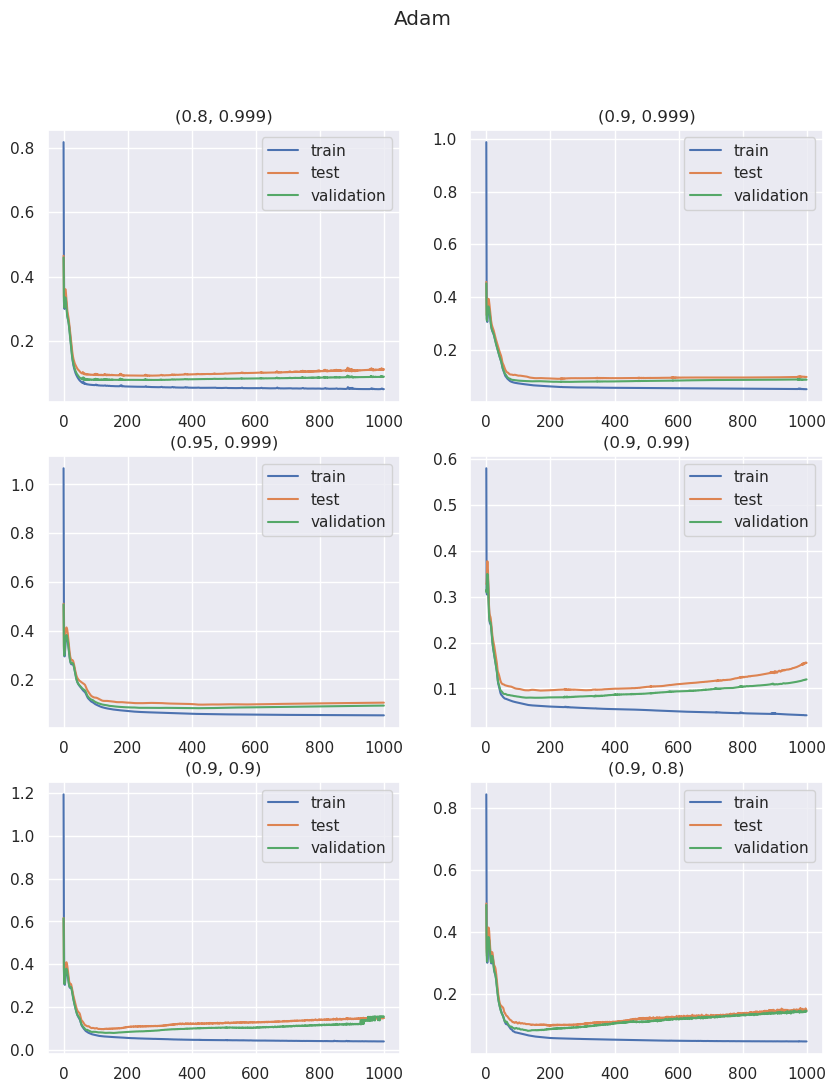

In [149]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(12)
fig.set_figwidth(10)
fig.suptitle('Adam')
for counter in range(len(BETAS)):
        ax[counter // 2][counter % 2].plot(loss_Adam_train[counter], label='train')
        ax[counter // 2][counter % 2].plot(loss_Adam_test[counter], label='test')
        ax[counter // 2][counter % 2].plot(loss_Adam_val[counter], label='validation')
        ax[counter // 2][counter % 2].legend()
        ax[counter // 2][counter % 2].set_title(f'{BETAS[counter]}')


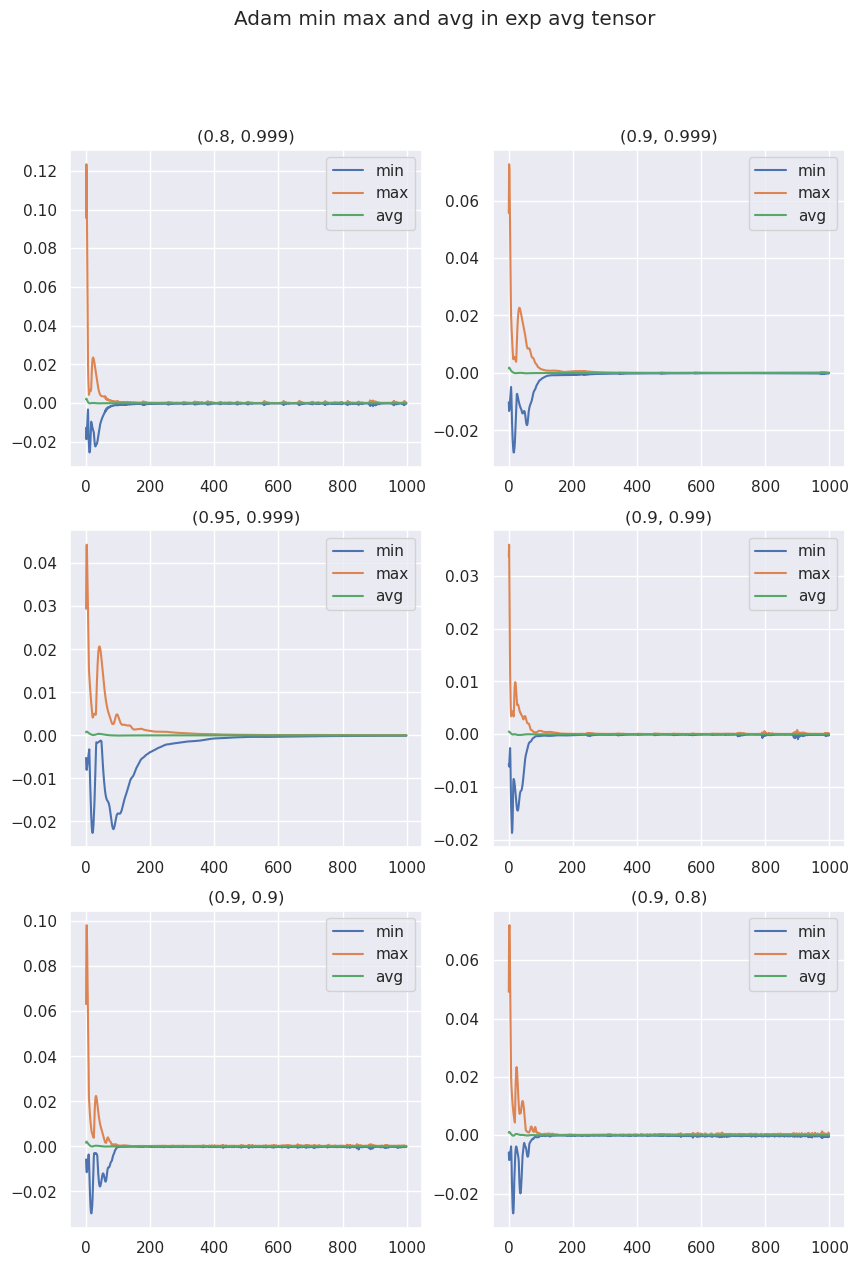

In [156]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(14)
fig.set_figwidth(10)
fig.suptitle('Adam min max and avg in exp avg tensor')
for counter in range(len(BETAS)):
        ax[counter // 2][counter % 2].set_title(f'{BETAS[counter]}')   
        ax[counter // 2][counter % 2].plot(min_lst[counter], label='min')
        ax[counter // 2][counter % 2].plot(max_lst[counter], label='max')
        ax[counter // 2][counter % 2].plot(avg_lst[counter], label='avg')
        ax[counter // 2][counter % 2].legend()

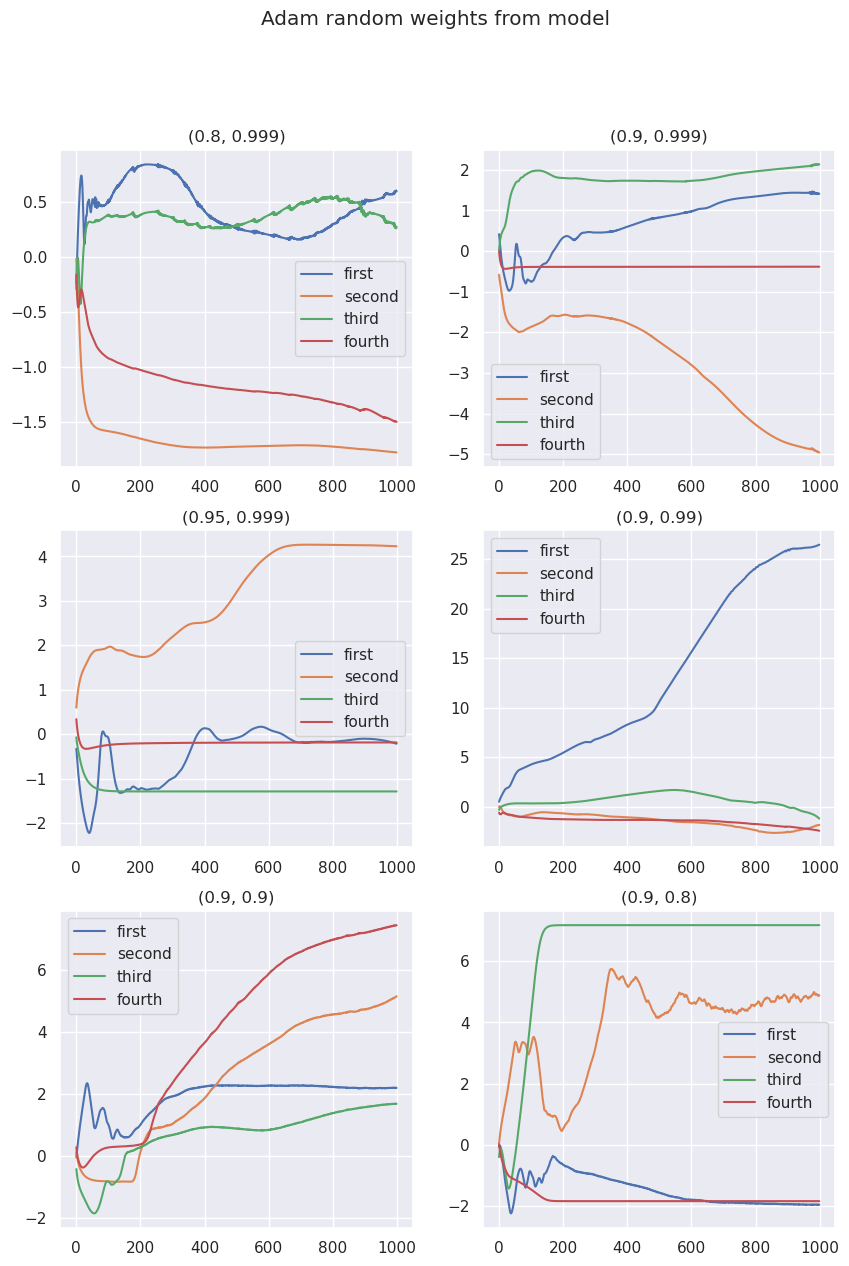

In [155]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(14)
fig.set_figwidth(10)
fig.suptitle('Adam random weights from model')
for counter in range(len(BETAS)):

        ax[counter // 2][counter % 2].set_title(f'{BETAS[counter]}')   
        ax[counter // 2][counter % 2].plot(first_lst[counter], label='first')
        ax[counter // 2][counter % 2].plot(second_lst[counter], label='second')
        ax[counter // 2][counter % 2].plot(third_lst[counter], label='third')
        ax[counter // 2][counter % 2].plot(fourth_lst[counter], label='fourth')
        ax[counter // 2][counter % 2].legend()

In [157]:
for i, betas in enumerate(BETAS):
    print('train', loss_Adam_train[i][-1], 'Adadelta with betas =', betas)
    print('test', loss_Adam_test[i][-1], 'Adadelta with betas =', betas)

train 0.05041675642132759 Adadelta with betas = (0.8, 0.999)
test 0.11237425357103348 Adadelta with betas = (0.8, 0.999)
train 0.05075027048587799 Adadelta with betas = (0.9, 0.999)
test 0.09726149588823318 Adadelta with betas = (0.9, 0.999)
train 0.052710164338350296 Adadelta with betas = (0.95, 0.999)
test 0.10474921762943268 Adadelta with betas = (0.95, 0.999)
train 0.041558582335710526 Adadelta with betas = (0.9, 0.99)
test 0.15581044554710388 Adadelta with betas = (0.9, 0.99)
train 0.03946065902709961 Adadelta with betas = (0.9, 0.9)
test 0.14886964857578278 Adadelta with betas = (0.9, 0.9)
train 0.045333437621593475 Adadelta with betas = (0.9, 0.8)
test 0.14570434391498566 Adadelta with betas = (0.9, 0.8)


# Rprop

In [177]:
lr = 0.01
epochs = 500
model = MyNet(6, 10).to(device)

In [178]:
loss = nn.BCELoss()
optim = torch.optim.Rprop(model.parameters(), lr=lr)

In [179]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [180]:
loss_Rprop_train = []
loss_Rprop_val = []
loss_Rprop_test = []
classification_loss_Rprop_train = []
classification_loss_Rprop_val = []
classification_loss_Rprop_test = []

max_lst = []
min_lst = []
avg_lst = []

first_lst = []
second_lst = []
third_lst = []
fourth_lst = []

for epoch in tqdm(range(epochs)):
    tr = train(model, train_dataloader, loss, optim)
    vld = validation(model, val_dataloader, loss, optim)
    tst = validation(model, test_dataloader, loss, optim)
    loss_Rprop_train.append(tr[0])
    loss_Rprop_val.append(vld[0])
    loss_Rprop_test.append(tst[0])
    classification_loss_Rprop_train.append(tr[1])
    classification_loss_Rprop_val.append(vld[1])
    classification_loss_Rprop_test.append(tst[1])
    max_value_in_sum = float("-INF")
    min_value_in_sum = float("INF")
    sum_of_all_tensors = 0
    count_of_all_numbers = 0
    
    
    for i in optim.state.items():    
        min_value_in_sum = min(min_value_in_sum, i[1]['prev'].min())
        max_value_in_sum = max(max_value_in_sum, i[1]['prev'].max())
        sum_of_all_tensors += i[1]['prev'].sum()
        count_of_all_numbers += i[1]['prev'].numel()
    avg_of_all_tensors = sum_of_all_tensors / count_of_all_numbers
    
    min_lst.append(min_value_in_sum.cpu().item())
    max_lst.append(max_value_in_sum.cpu().item())
    avg_lst.append(avg_of_all_tensors.cpu().item())
    
    first_lst.append(model.linear1.weight[first].cpu().item())
    second_lst.append(model.linear2.weight[second].cpu().item())
    third_lst.append(model.linear3.weight[third].cpu().item())
    fourth_lst.append(model.linear4.weight[fourth].cpu().item())
    
    if epoch % 100 == 0:
        print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/500 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3750319182872772
loss on the 100's epoch is 0.09380672127008438
loss on the 200's epoch is 0.0933481901884079
loss on the 300's epoch is 0.09600439667701721
loss on the 400's epoch is 0.10277675837278366


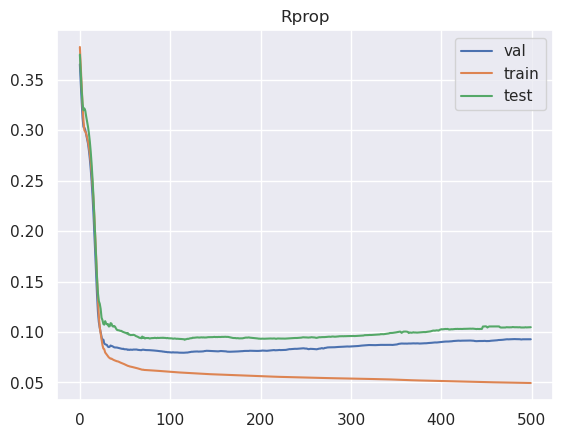

In [181]:
plt.plot(loss_Rprop_val, label='val')
plt.plot(loss_Rprop_train, label='train')
plt.plot(loss_Rprop_test, label='test')
plt.legend()
plt.title('Rprop');

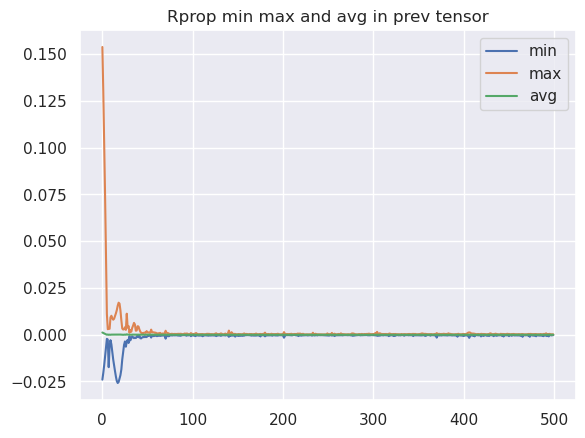

In [182]:
plt.plot(min_lst, label='min')
plt.plot(max_lst, label='max')
plt.plot(avg_lst, label='avg')
plt.legend()
plt.title('Rprop min max and avg in prev tensor');

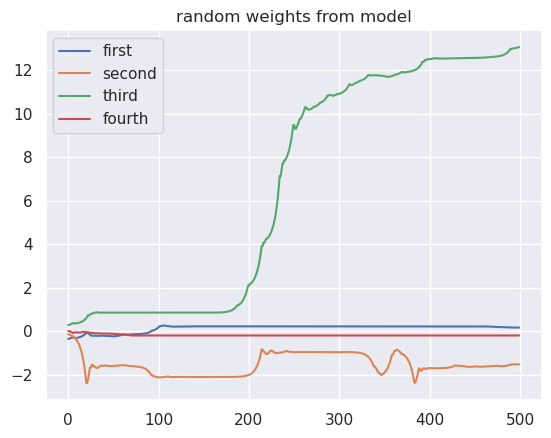

In [183]:
plt.plot(first_lst, label='first')
plt.plot(second_lst, label='second')
plt.plot(third_lst, label='third')
plt.plot(fourth_lst, label='fourth')
plt.legend()
plt.title('random weights from model');

In [184]:
print(loss_Rprop_train[-1], loss_Rprop_test[-1])

0.049487095326185226 0.10479938983917236


# SGD

In [33]:
lr = 0.1
epochs = 1000

In [43]:
train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

SIZE = [1, 20, 100, len(test_data)]

for size in SIZE:
    train_dataloaders.append(DataLoader(train_data, batch_size=size, shuffle=True))
    val_dataloaders.append(DataLoader(val_data, batch_size=size))
    test_dataloaders.append(DataLoader(test_data, batch_size=size))


In [44]:
EPOCHS = [10, 50, 200, 1000]

In [46]:
loss_SGD_train = np.empty((len(EPOCHS), max(EPOCHS)))
loss_SGD_val = np.empty((len(EPOCHS), max(EPOCHS)))
loss_SGD_test = np.empty((len(EPOCHS), max(EPOCHS)))
classification_loss_SGD_train = np.empty((len(EPOCHS), max(EPOCHS)))
classification_loss_SGD_val = np.empty((len(EPOCHS), max(EPOCHS)))
classification_loss_SGD_test = np.empty((len(EPOCHS), max(EPOCHS)))


for i in tqdm(range(len(SIZE))):
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epochs in tqdm(range(EPOCHS[i]), leave=False):
        tr = train(model, train_dataloaders[i], loss, optim)
        vld = validation(model, val_dataloaders[i], loss, optim)
        tst = validation(model, test_dataloaders[i], loss, optim)
        loss_SGD_train[i][epochs] = tr[0]
        loss_SGD_val[i][epochs] = vld[0]
        loss_SGD_test[i][epochs] = tst[0]
        classification_loss_SGD_train[i][epochs] = tr[1]
        classification_loss_SGD_val[i][epochs] = vld[1]
        classification_loss_SGD_test[i][epochs] = tst[1]

        if epochs % (EPOCHS[i] //10) == 0:
            print(f"loss on the {epochs}'s epoch is {tst[0]}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

loss on the 0's epoch is 0.08129176164966846
loss on the 1's epoch is 0.07816600878079104
loss on the 2's epoch is 0.08355763871899113
loss on the 3's epoch is 0.07474809128611593
loss on the 4's epoch is 0.07660137686427089
loss on the 5's epoch is 0.07452518782843758
loss on the 6's epoch is 0.07276263589757448
loss on the 7's epoch is 0.09108014388670677
loss on the 8's epoch is 0.0789764354253245
loss on the 9's epoch is 0.07463736638879434


  0%|          | 0/50 [00:00<?, ?it/s]

loss on the 0's epoch is 0.2749808124370045
loss on the 5's epoch is 0.09664557504778107
loss on the 10's epoch is 0.08453243953279323
loss on the 15's epoch is 0.07886733176807563
loss on the 20's epoch is 0.07718566916882992
loss on the 25's epoch is 0.07598762255575922
loss on the 30's epoch is 0.07350786667213671
loss on the 35's epoch is 0.0720254463247127
loss on the 40's epoch is 0.07036216958529419
loss on the 45's epoch is 0.06991639868873689


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.27581943571567535
loss on the 20's epoch is 0.09616961723400487
loss on the 40's epoch is 0.08409527109728919
loss on the 60's epoch is 0.08237307601504856
loss on the 80's epoch is 0.08054683357477188
loss on the 100's epoch is 0.07884446841975053
loss on the 120's epoch is 0.07789789952544703
loss on the 140's epoch is 0.07682743021804425
loss on the 160's epoch is 0.07640339227186309
loss on the 180's epoch is 0.07481089234352112


  0%|          | 0/1000 [00:00<?, ?it/s]

loss on the 0's epoch is 0.6113954186439514
loss on the 100's epoch is 0.2659394443035126
loss on the 200's epoch is 0.20538045465946198
loss on the 300's epoch is 0.11912599205970764
loss on the 400's epoch is 0.09357030689716339
loss on the 500's epoch is 0.08711451292037964
loss on the 600's epoch is 0.08476873487234116
loss on the 700's epoch is 0.08375073224306107
loss on the 800's epoch is 0.08313031494617462
loss on the 900's epoch is 0.0825895220041275


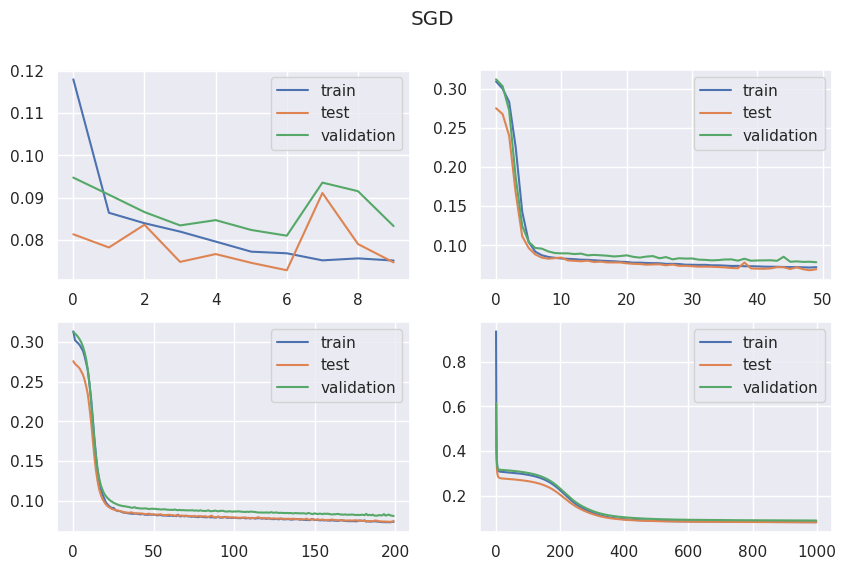

In [49]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('SGD')
for counter in range(len(SIZE)):
        ax[counter // 2][counter % 2].plot(loss_SGD_train[counter][:EPOCHS[counter]], label='train')
        ax[counter // 2][counter % 2].plot(loss_SGD_test[counter][:EPOCHS[counter]], label='test')
        ax[counter // 2][counter % 2].plot(loss_SGD_val[counter][:EPOCHS[counter]], label='validation')
        ax[counter // 2][counter % 2].legend()
        


In [74]:
losses_train = []
losses_test = []
for i in range(len(SIZE)):
    losses_train.append(loss_SGD_train[i, EPOCHS[i] - 1])
    losses_test.append(loss_SGD_test[i, EPOCHS[i] - 1])

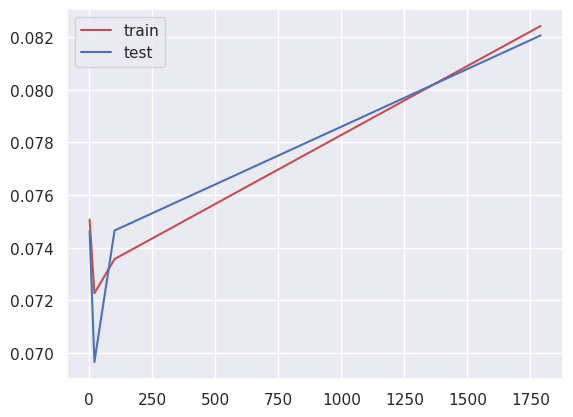

In [77]:
plt.plot(SIZE, losses_train, label='train', color='r')
plt.plot(SIZE, losses_test, label='test', color='b')
plt.legend()

In [78]:
print(losses_train, 'train')
print(losses_test, 'test')

[0.07506805896311085, 0.07226981959536366, 0.07357012237318689, 0.08242268487811089] train
[0.07463736638879434, 0.06965923955560559, 0.07465480692270729, 0.08206130564212799] test


# BarPlot of bests models

In [108]:
string = 'GD, GDM, NAG, SGD, AdaGrad, RMSProp, AdaDelta, RProp, Adam'.split(', ')
epoches = [1000, 1000, 1000, 100, 1000, 1000, 1000, 500, 1000]

<Axes: >

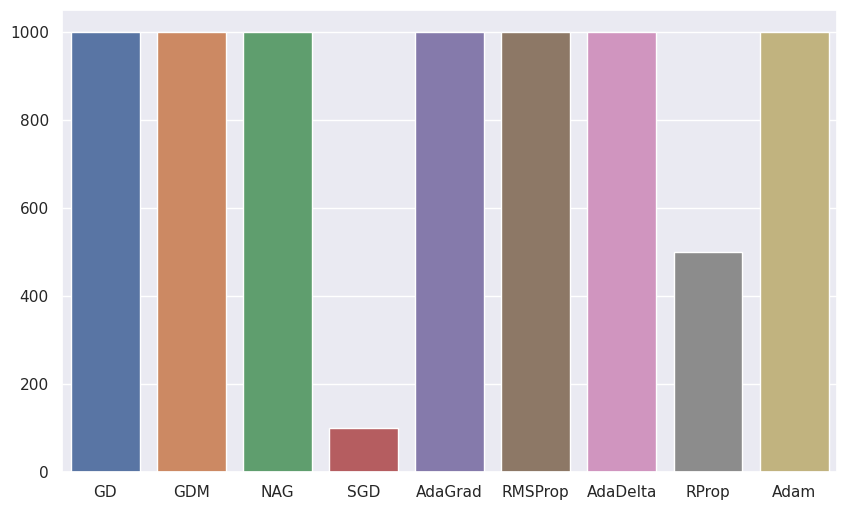

In [109]:
plt.figure(figsize=[10, 6])
sns.barplot(x=string, y=epoches)

In [111]:
results_train = [0.0719839408993721, 0.0672072172164917,
                 0.0768674996117961, 0.06557592419321062,
                 0.06207096576690674, 0.052446164190769196,
                 0.07502277195453644, 0.05075027048587799,
                 0.049487095326185226]
results_test = [0.06682001054286957, 0.06160445511341095,
                0.06453176522952656, 0.08606926082736915,
                0.08715248852968216, 0.10866910964250565,
                0.10587729513645172, 0.09726149588823318,
                0.10479938983917236]

<Axes: >

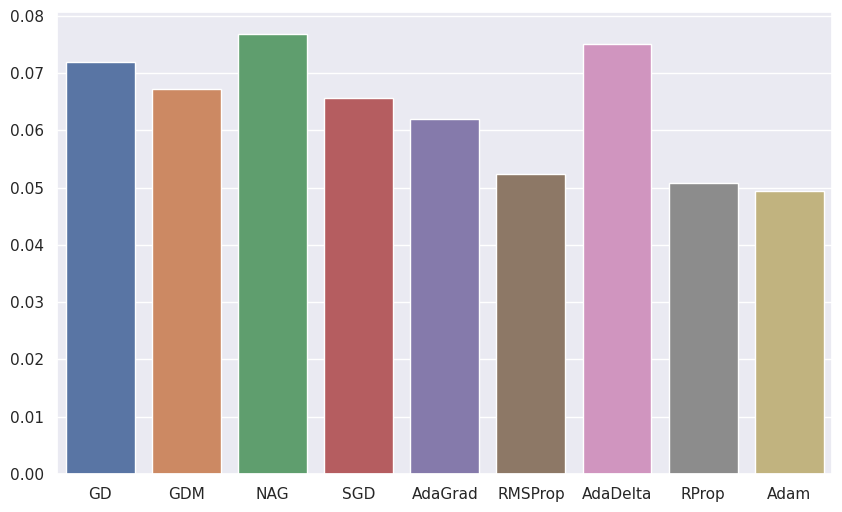

In [112]:
plt.figure(figsize=[10, 6])
sns.barplot(x=string, y=results_train)

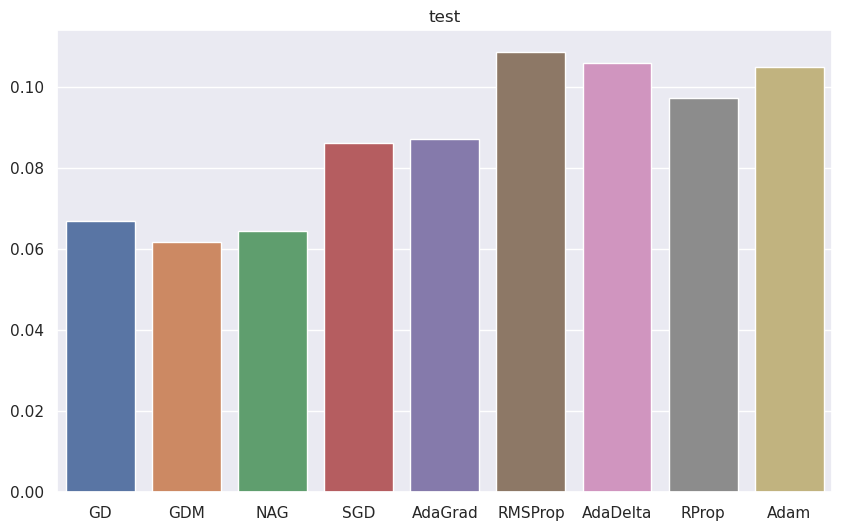

In [115]:
plt.figure(figsize=[10, 6])
sns.barplot(x=string, y=results_test)
plt.title('test');

# model parameters 

In [126]:
def uniform_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.uniform_(m.weight, b=__std_param)

def normal_init(m):
    if isinstance(m, nn)

In [129]:
lr = 10
epochs = 200
number_of_times = 10

In [130]:
first = np.random.randint(model.linear1.out_features), \
        np.random.randint(model.linear1.in_features)
second = np.random.randint(model.linear2.out_features), \
        np.random.randint(model.linear2.in_features)
third = np.random.randint(model.linear3.out_features), \
        np.random.randint(model.linear3.in_features)
fourth = np.random.randint(model.linear4.out_features), \
        np.random.randint(model.linear4.in_features)

In [131]:
in_feat = np.array([model.linear1.in_features, 
                    model.linear2.in_features,
                    model.linear3.in_features,
                    model.linear4.in_features])

out_feat =np.array([model.linear1.out_features,
                    model.linear2.out_features,
                    model.linear3.out_features,
                    model.linear4.out_features])
0.42640143
std = np.sqrt(2 / (in_feat + out_feat))

In [132]:
SIGMAS = np.unique(std)
SIGMAS

array([0.31622777, 0.35355339, 0.42640143])

In [133]:
METHODS = ['uniform', 'normal', 'trunc_normal']

In [134]:
loss_init_val = np.empty((len(SIGMAS), number_of_times, epochs))
loss_init_test = np.empty((len(SIGMAS), number_of_times, epochs))
loss_init_train = np.empty((len(SIGMAS), number_of_times, epochs))

first_lst = np.empty((len(SIGMAS), number_of_times, epochs))
second_lst = np.empty((len(SIGMAS), number_of_times, epochs))
third_lst = np.empty((len(SIGMAS), number_of_times, epochs))
fourth_lst = np.empty((len(SIGMAS), number_of_times, epochs))


for i, sigma in tqdm(enumerate(SIGMAS), total=len(SIGMAS)):

    for j in tqdm(range(number_of_times), leave=False):

        model = MyNet(6, 10).to(device)
        __std_param = sigma
        model.apply(uniform_init)
        
        loss = nn.BCELoss()
        optim = torch.optim.SGD(model.parameters(), lr=lr)


        for epoch in tqdm(range(epochs), leave=False):
            tr = train(model, train_dataloader, loss, optim)
            vld = validation(model, val_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)
            loss_init_train[i][j] = tr[0]
            loss_init_val[i][j] = vld[0]
            loss_init_test[i][j] = tst[0]

            first_lst[i][j][epoch] = model.linear1.weight[first].cpu().item()
            second_lst[i][j][epoch] = model.linear2.weight[second].cpu().item()
            third_lst[i][j][epoch] = model.linear3.weight[third].cpu().item()
            fourth_lst[i][j][epoch] = model.linear4.weight[fourth].cpu().item()

            if epoch % 40 == 0:
                print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 2.625216245651245
loss on the 40's epoch is 0.21760553121566772
loss on the 80's epoch is 0.10342706739902496
loss on the 120's epoch is 0.08406054973602295
loss on the 160's epoch is 0.0821400061249733


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 2.5436019897460938
loss on the 40's epoch is 0.2744218111038208
loss on the 80's epoch is 0.15200011432170868
loss on the 120's epoch is 0.08399954438209534
loss on the 160's epoch is 0.08162160217761993


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 2.745940923690796
loss on the 40's epoch is 0.1653815358877182
loss on the 80's epoch is 0.08892160654067993
loss on the 120's epoch is 0.08346161246299744
loss on the 160's epoch is 0.09164199978113174


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.4249508380889893
loss on the 40's epoch is 0.3185439705848694
loss on the 80's epoch is 0.13964775204658508
loss on the 120's epoch is 0.08790923655033112
loss on the 160's epoch is 0.08166813850402832


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.351314067840576
loss on the 40's epoch is 0.3138909637928009
loss on the 80's epoch is 0.1023319810628891
loss on the 120's epoch is 0.08525750786066055
loss on the 160's epoch is 0.08907635509967804


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.1351358890533447
loss on the 40's epoch is 0.12608513236045837
loss on the 80's epoch is 0.0872315913438797
loss on the 120's epoch is 0.08281303197145462
loss on the 160's epoch is 0.10144094377756119


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.2202823162078857
loss on the 40's epoch is 0.24156969785690308
loss on the 80's epoch is 0.09357038885354996
loss on the 120's epoch is 0.08301263302564621
loss on the 160's epoch is 0.08689318597316742


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.004786968231201
loss on the 40's epoch is 0.25251972675323486
loss on the 80's epoch is 0.10038501024246216
loss on the 120's epoch is 0.08537083864212036
loss on the 160's epoch is 0.08395814895629883


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 2.8299028873443604
loss on the 40's epoch is 0.19531197845935822
loss on the 80's epoch is 0.08958202600479126
loss on the 120's epoch is 0.08302133530378342
loss on the 160's epoch is 0.08829613029956818


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 2.9451003074645996
loss on the 40's epoch is 0.2603856325149536
loss on the 80's epoch is 0.1187615692615509
loss on the 120's epoch is 0.08593869209289551
loss on the 160's epoch is 0.0837312564253807


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.0075032711029053
loss on the 40's epoch is 0.312448114156723
loss on the 80's epoch is 0.15268446505069733
loss on the 120's epoch is 0.084529347717762
loss on the 160's epoch is 0.08893457800149918


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.2228667736053467
loss on the 40's epoch is 0.19009347259998322
loss on the 80's epoch is 0.08848148584365845
loss on the 120's epoch is 0.08181119710206985
loss on the 160's epoch is 0.07978469878435135


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.663149118423462
loss on the 40's epoch is 3.6320960521698
loss on the 80's epoch is 3.5866756439208984
loss on the 120's epoch is 3.500938892364502
loss on the 160's epoch is 0.320593923330307


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.6383676528930664
loss on the 40's epoch is 3.6008548736572266
loss on the 80's epoch is 3.54018235206604
loss on the 120's epoch is 3.3657381534576416
loss on the 160's epoch is 0.2674832046031952


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.8988029956817627
loss on the 40's epoch is 3.8960959911346436
loss on the 80's epoch is 3.893312454223633
loss on the 120's epoch is 3.890448570251465
loss on the 160's epoch is 3.887500047683716


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.4018821716308594
loss on the 40's epoch is 0.3163152039051056
loss on the 80's epoch is 0.3408570885658264
loss on the 120's epoch is 0.08592553436756134
loss on the 160's epoch is 0.0809938907623291


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.2361671924591064
loss on the 40's epoch is 0.16362060606479645
loss on the 80's epoch is 0.08716993778944016
loss on the 120's epoch is 0.08171495050191879
loss on the 160's epoch is 0.08699335157871246


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.38842511177063
loss on the 40's epoch is 0.30670854449272156
loss on the 80's epoch is 2.1299569606781006
loss on the 120's epoch is 0.08574404567480087
loss on the 160's epoch is 0.08364611119031906


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.749650716781616
loss on the 40's epoch is 3.738931655883789
loss on the 80's epoch is 3.7268929481506348
loss on the 120's epoch is 3.7131640911102295
loss on the 160's epoch is 3.697194814682007


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.397347927093506
loss on the 40's epoch is 0.22323372960090637
loss on the 80's epoch is 0.09606599807739258
loss on the 120's epoch is 0.08241210132837296
loss on the 160's epoch is 0.07994595915079117


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.066521167755127
loss on the 40's epoch is 4.066168785095215
loss on the 80's epoch is 4.065814971923828
loss on the 120's epoch is 4.065460205078125
loss on the 160's epoch is 4.0651044845581055


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.8754804134368896
loss on the 40's epoch is 3.872488260269165
loss on the 80's epoch is 3.8694050312042236
loss on the 120's epoch is 3.8662238121032715
loss on the 160's epoch is 3.862938165664673


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.0922627449035645
loss on the 40's epoch is 4.091829299926758
loss on the 80's epoch is 4.091393947601318
loss on the 120's epoch is 4.090956687927246
loss on the 160's epoch is 4.090517520904541


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.066710948944092
loss on the 40's epoch is 4.066172122955322
loss on the 80's epoch is 4.06563138961792
loss on the 120's epoch is 4.065086841583252
loss on the 160's epoch is 4.064539909362793


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.355180740356445
loss on the 40's epoch is 4.355140686035156
loss on the 80's epoch is 4.355101108551025
loss on the 120's epoch is 4.355061054229736
loss on the 160's epoch is 4.355020999908447


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.1295084953308105
loss on the 40's epoch is 4.129247188568115
loss on the 80's epoch is 4.128983497619629
loss on the 120's epoch is 4.128718852996826
loss on the 160's epoch is 4.128454208374023


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.9150147438049316
loss on the 40's epoch is 3.912247657775879
loss on the 80's epoch is 3.909398317337036
loss on the 120's epoch is 3.906466484069824
loss on the 160's epoch is 3.903444766998291


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.0721330642700195
loss on the 40's epoch is 4.071638107299805
loss on the 80's epoch is 4.071140766143799
loss on the 120's epoch is 4.07064151763916
loss on the 160's epoch is 4.0701398849487305


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 4.316845417022705
loss on the 40's epoch is 4.316816806793213
loss on the 80's epoch is 4.316788196563721
loss on the 120's epoch is 4.3167595863342285
loss on the 160's epoch is 4.3167314529418945


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 3.981839656829834
loss on the 40's epoch is 3.9805827140808105
loss on the 80's epoch is 3.979309320449829
loss on the 120's epoch is 3.9780194759368896
loss on the 160's epoch is 3.976712942123413


# Cross - validation 

In [149]:
from sklearn.model_selection import KFold, LeaveOneOut

In [158]:
all_features = np.vstack((x_train, x_test))
all_target = np.vstack((y_train, y_test))
all_features.shape

(12529, 6)

In [156]:
epochs = 200

In [173]:
loo = LeaveOneOut()
kfold = KFold(10)
device = 'cpu'

optim = torch.optim.SGD(model.parameters(), lr=10)

In [185]:
loss_loo_train = np.empty((10, 300))
loss_loo_test = np.empty((10, 300))

for j in tqdm(range(10)):
    loss = nn.BCELoss()
    model = MyNet(6, 10)
    optim = torch.optim.SGD(model.parameters(), lr=10)
    for i, loo_ind in tqdm(enumerate(loo.split(all_features)), total=300):
        if i >= 300:
            break
        tens_dataset_tr = TensorDataset(torch.FloatTensor(all_features[loo_ind[0]]), 
                                        torch.FloatTensor(all_target[loo_ind[0]]))
        tr_dataloader = DataLoader(tens_dataset_tr, shuffle=True, batch_size=len(tens_dataset_tr))

        tens_dataset_tst = TensorDataset(torch.FloatTensor(all_features[loo_ind[1]]), 
                                         torch.FloatTensor(all_target[loo_ind[1]]))
        tst_dataloader =  DataLoader(tens_dataset_tst)

        tr = train(model, tr_dataloader, loss, optim)
        tst = validation(model, test_dataloader, loss, optim)

        loss_loo_train[j][i] = tr[0]
        loss_loo_test[j][i] = tst[0]        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [187]:
print('avg', loss_loo_train[:, -1].mean(), 
      'std',loss_loo_train[:, -1].std())
print('avg',loss_loo_test[:, -1].mean(),  
      'std',loss_loo_test[:, -1].std())

avg 0.07966148629784583 std 0.0012090311912784392
avg 0.08063958287239074 std 0.001268369568372356


In [215]:
epochs = 1000
model = MyNet(6, 10).cpu()
loss = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=1)
device = 'cpu'

In [217]:
loss_hold_train = []
loss_hold_val = []
loss_hold_test = []



for i in tqdm(range(epochs)):
    tr = train(model, train_dataloader, loss, optim)
    vld = validation(model, val_dataloader, loss, optim)
    tst = validation(model, test_dataloader, loss, optim)
    loss_hold_train.append(tr[0])
    loss_hold_val.append(vld[0])
    loss_hold_test.append(tst[0])
    if i % 50 == 0:
        print(loss_hold_test[i])

  0%|          | 0/1000 [00:00<?, ?it/s]

0.32419824600219727
0.30607473850250244
0.2959675192832947
0.2658890187740326
0.17889724671840668
0.11737917363643646
0.10029835253953934
0.09380123764276505
0.09089912474155426
0.08961239457130432
0.08898581564426422
0.08857588469982147
0.08822070807218552
0.08787055313587189
0.0875108540058136
0.08713682740926743
0.08674782514572144
0.08634693920612335
0.0859391987323761
0.08552704751491547


In [218]:
print(loss_hold_train[-1], loss_hold_test[-1])

0.08135450631380081 0.08511654287576675


In [222]:
loss_kfold_train = np.empty((10, 1000))
loss_kfold_test = np.empty((10, 1000))
for j, data in tqdm(enumerate(kfold.split(all_features)), total=kfold.get_n_splits(), leave=False):
        loss = nn.BCELoss()
        model = MyNet(6, 10)
        optim = torch.optim.SGD(model.parameters(), lr=lr)
        tens_dataset_tr = TensorDataset(torch.FloatTensor(all_features[data[0]]), 
                                        torch.FloatTensor(all_target[data[0]]))
        tr_dataloader = DataLoader(tens_dataset_tr, shuffle=True, batch_size=len(tens_dataset_tr))
        
        tens_dataset_tst = TensorDataset(torch.FloatTensor(all_features[data[1]]), 
                                         torch.FloatTensor(all_target[data[1]]))
        tst_dataloader =  DataLoader(tens_dataset_tst, )
        for epoch in tqdm(range(epochs), leave=False):
            tr = train(model, tr_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)

            loss_kfold_train[j][epoch] = tr[0]
            loss_kfold_test[j][epoch] = tst[0]        


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [232]:
print('avg', loss_kfold_train[:, -1].mean(), 
        'std',loss_kfold_train[:, -1].std())
print('avg',loss_kfold_test[:, -1].mean(),  
        'std',loss_kfold_test[:, -1].std())

avg 0.07985012605786324 std 0.0009349433217142915
avg 0.08168113827705384 std 0.0011960019705194106


In [240]:
validation(model, train_dataloader, loss, optim)

(0.07949858158826828, 0.023186516016721725)

In [235]:
loss_monte_train = np.empty((10, 1000))
loss_monte_test = np.empty((10, 1000))
for j in tqdm(range(5)):
        loss = nn.BCELoss()
        model = MyNet(6, 10)
        all_index = np.random.permutation(np.arange(len(all_features)))
        data = all_index[:round(0.6 * len(all_features))], all_index[round(0.6 * len(all_features)):]
        optim = torch.optim.SGD(model.parameters(), lr=lr)
        tens_dataset_tr = TensorDataset(torch.FloatTensor(all_features[data[0]]), 
                                        torch.FloatTensor(all_target[data[0]]))
        tr_dataloader = DataLoader(tens_dataset_tr, shuffle=True, batch_size=len(tens_dataset_tr))
        
        tens_dataset_tst = TensorDataset(torch.FloatTensor(all_features[data[1]]), 
                                         torch.FloatTensor(all_target[data[1]]))
        tst_dataloader =  DataLoader(tens_dataset_tst, )
        for epoch in tqdm(range(epochs), leave=False):
            tr = train(model, tr_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)

            loss_monte_train[j][epoch] = tr[0]
            loss_monte_test[j][epoch] = tst[0]        


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [236]:
print('avg', loss_monte_train[:, -1].mean(), 
        'std',loss_monte_train[:, -1].std())
print('avg',loss_monte_test[:, -1].mean(),  
        'std',loss_monte_test[:, -1].std())

avg 0.04833479300141334 std 0.03947430597164786
avg 0.041304894536733625 std 0.041314960014760205


# Regularization

In [217]:
LAMBDAS  = [0.01, 0.1, 0.5, 5]
lr = 1e-2
epochs = 200

In [218]:
loss = nn.BCELoss()
optim = torch.optim.Adagrad(model.parameters(), lr=lr)

In [221]:
def train_regul_l1(net, dataloader, criterion, optimizer, l1=0, l2=0):
    net.train()
    total_loss = 0
    classification_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(x_batch)
        
        norm1 = 0
        norm2 = 0
        for p in net.parameters():
            norm1 += p.abs().sum()
        
        for p in net.parameters():
            norm2 += (p ** 2).sum()
            
        loss = criterion(y_pred, y_batch) 
        loss_with_norm = loss + l1 * norm1 + l2 * norm2
        classification_loss += classification(y_pred, y_batch).item()
        total_loss += loss.item()
        loss_with_norm.backward()
        optimizer.step()
    return total_loss / len(dataloader), classification_loss / len(dataloader)

In [224]:
loss_regul1_train = np.empty((2, len(LAMBDAS), epochs))
loss_regul1_val = np.empty((2, len(LAMBDAS), epochs))
loss_regul1_test = np.empty((2, len(LAMBDAS), epochs))
norm = np.empty((2, len(LAMBDAS), epochs))

for l in range(2):
    for i in tqdm(range(len(LAMBDAS))):
        model = MyNet(6, 100).to(device)
        loss = nn.BCELoss()
        optim = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in tqdm(range(epochs), leave=False):
            tr = train_regul_l1(model, train_dataloader, loss, optim, 
                                l1=l*LAMBDAS[i], l2 = (1-l)*LAMBDAS[i])
            vld = validation(model, val_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)

            loss_regul1_train[l][i][epoch] = tr[0]
            loss_regul1_val[l][i][epoch] = vld[0]
            loss_regul1_test[l][i][epoch] = tst[0]

            norm[l][i][epoch] = 0
            for p in model.parameters():
                norm[l][i][epoch] += l * p.abs().sum() + (1-l) * (p ** 2).sum()
            if epoch % 50 == 0:
                print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3289708197116852
loss on the 50's epoch is 0.32265493273735046
loss on the 100's epoch is 0.3226949870586395
loss on the 150's epoch is 0.3227130174636841


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3594333529472351
loss on the 50's epoch is 0.3230646550655365
loss on the 100's epoch is 0.3231724798679352
loss on the 150's epoch is 0.32316839694976807


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.8360868096351624
loss on the 50's epoch is 0.33550140261650085
loss on the 100's epoch is 0.33707955479621887
loss on the 150's epoch is 0.3370090425014496


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.48879343271255493
loss on the 50's epoch is 0.4812720715999603
loss on the 100's epoch is 0.4840231239795685
loss on the 150's epoch is 0.4842377007007599


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3994297385215759
loss on the 50's epoch is 0.32278794050216675
loss on the 100's epoch is 0.3237041234970093
loss on the 150's epoch is 0.32362261414527893


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.386170357465744
loss on the 50's epoch is 0.40893593430519104
loss on the 100's epoch is 0.4153408706188202
loss on the 150's epoch is 0.3775700330734253


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.3587495684623718
loss on the 50's epoch is 0.6636029481887817
loss on the 100's epoch is 0.6768175959587097
loss on the 150's epoch is 0.659507155418396


  0%|          | 0/200 [00:00<?, ?it/s]

loss on the 0's epoch is 0.6829515695571899
loss on the 50's epoch is 0.6833086609840393
loss on the 100's epoch is 0.685601532459259
loss on the 150's epoch is 0.6971490383148193


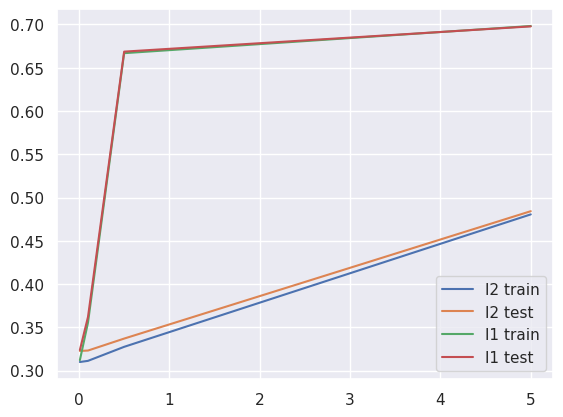

In [225]:
plt.plot(LAMBDAS, loss_regul1_train[0, :, -1], label='l2 train')
plt.plot(LAMBDAS, loss_regul1_test[0, :, -1], label='l2 test')
plt.plot(LAMBDAS, loss_regul1_train[1, :, -1], label='l1 train')
plt.plot(LAMBDAS, loss_regul1_test[1, :, -1], label='l1 test')
plt.legend()

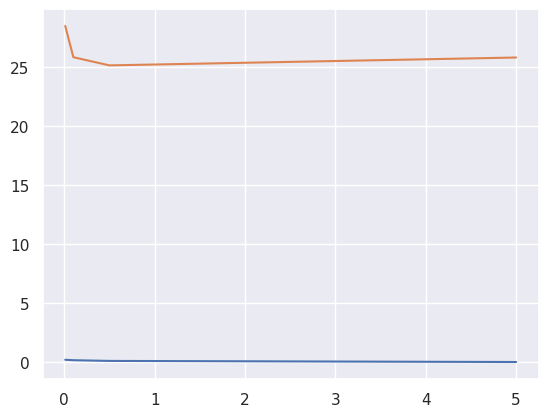

In [227]:
plt.plot(LAMBDAS, norm[0, :, -1], label='l2')
plt.plot(LAMBDAS, norm[1, :, -1], label='l1')

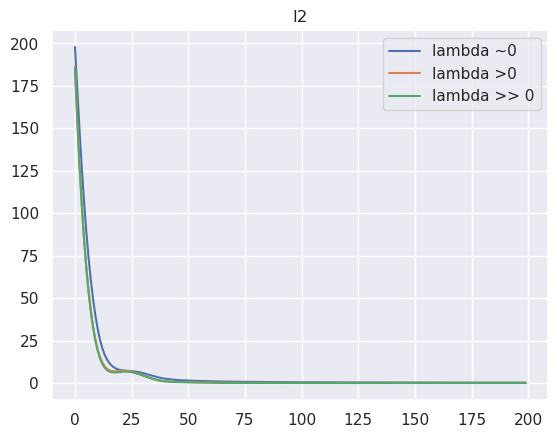

In [232]:
plt.plot(norm[0, 0, :], label='lambda ~0')
plt.plot(norm[0, 2, :], label='lambda >0')
plt.plot(norm[0, 3, :], label='lambda >> 0')
plt.legend()
plt.title('l2');

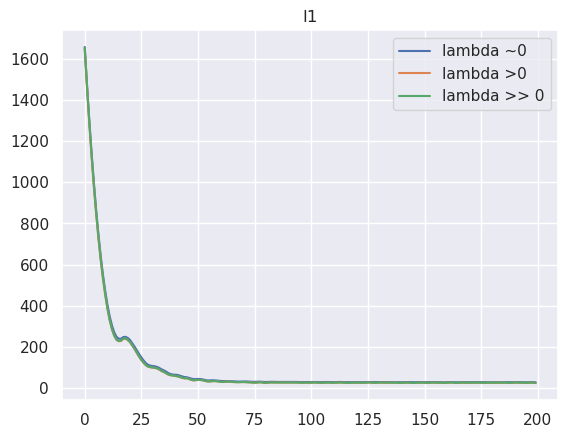

In [233]:
plt.plot(norm[1, 0, :], label='lambda ~0')
plt.plot(norm[1, 2, :], label='lambda >0')
plt.plot(norm[1, 3, :], label='lambda >> 0')
plt.legend()
plt.title('l1');

# Best model

In [33]:
from IPython.display import clear_output

In [34]:
model = MyNet(6, 10).to(device)
lr = 1
epochs = 1000
loss = torch.nn.BCELoss()
optim = torch.optim.SGD(params=model.parameters(), momentum=0.9, lr=lr)

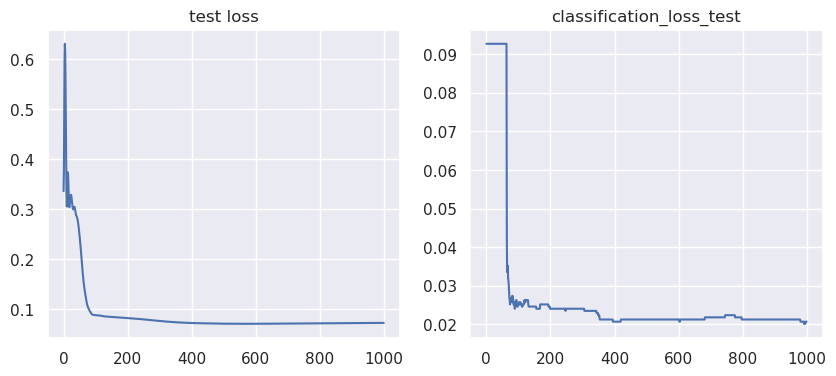

In [35]:
loss_train = []
loss_val = []
loss_test = []

classification_loss_train = []
classification_loss_val = []
classification_loss_test = []

for i in range(epochs):
    tr = train(model, train_dataloader, loss, optim)
    vld = validation(model, val_dataloader, loss, optim)
    tst = validation(model, test_dataloader, loss, optim)
    loss_train.append(tr[0])
    loss_val.append(vld[0])
    loss_test.append(tst[0])
    classification_loss_train.append(tr[1])
    classification_loss_val.append(vld[1])
    classification_loss_test.append(tst[1])
    
    if (i + 1) % 10 == 0:
        clear_output(True)
        fig, ax = plt.subplots(1, 2)
        fig.set_figheight(4)
        fig.set_figwidth(10)
        ax[0].set_title('test loss')
        ax[0].plot(loss_test)
        ax[1].set_title('classification_loss_test')
        ax[1].plot(classification_loss_test)
        plt.show()

In [51]:
output_train = model(torch.FloatTensor(x_train)).detach().cpu() > 0.5
output_test = model(torch.FloatTensor(x_test)).detach().cpu() > 0.5

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [53]:
confusion_matrix(output_train, y_train)

array([[9675,  147],
       [  63,  854]])

In [54]:
confusion_matrix(output_test, y_test)

array([[1613,   26],
       [  11,  140]])

# Vizualization 1st layer's parameters

<Axes: >

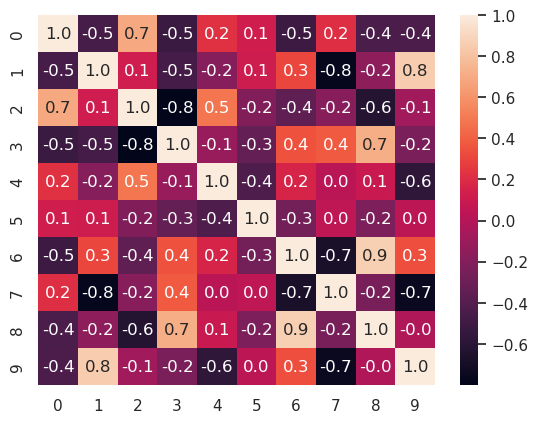

In [71]:
sns.heatmap(model.linear1.weight.data.corrcoef(), annot=True, fmt='.1f')

In [72]:
print(classification_loss_test[-1], classification_loss_train[-1])

0.020670391619205475 0.01955489255487919


# Best architecture

In [105]:
epochs = 200
lr = 1
device = 'cpu'
Number_of_neurons = [5, 10, 20, 40, 50, 100]
kfold = KFold(10)
n = kfold.get_n_splits()

In [113]:
losses_train = np.empty((len(Number_of_neurons), n, epochs))
losses_test = np.empty((len(Number_of_neurons), n, epochs))
losses_val = np.empty((len(Number_of_neurons),  n, epochs))

for i, number in tqdm(enumerate(Number_of_neurons), total=len(Number_of_neurons)):
    
    for j, data in tqdm(enumerate(kfold.split(x_train)), total=n, leave=False):
        loss = nn.BCELoss()
        model = MyNet(6, number)
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        tens_dataset_tr = TensorDataset(torch.FloatTensor(x_train[data[0]]), 
                                        torch.FloatTensor(y_train[data[0]]))
        tr_dataloader = DataLoader(tens_dataset_tr, shuffle=True, batch_size=len(tens_dataset_tr))
        
        tens_dataset_tst = TensorDataset(torch.FloatTensor(x_train[data[1]]), 
                                         torch.FloatTensor(y_train[data[1]]))
        tst_dataloader =  DataLoader(tens_dataset_tst, )
        for epoch in tqdm(range(epochs), leave=False):
            tr = train(model, tr_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)

            losses_train[i][j][epoch] = tr[0]
            losses_test[i][j][epoch] = tst[0]        

            if epoch % 50 == 0:
                print(f"loss with Number_of_neurons = {number} on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.414162814617157
loss with Number_of_neurons = 5 on the 50's epoch is 0.26579493284225464
loss with Number_of_neurons = 5 on the 100's epoch is 0.09058787673711777
loss with Number_of_neurons = 5 on the 150's epoch is 0.08605075627565384


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.3840213716030121
loss with Number_of_neurons = 5 on the 50's epoch is 0.11118566244840622
loss with Number_of_neurons = 5 on the 100's epoch is 0.08777061104774475
loss with Number_of_neurons = 5 on the 150's epoch is 0.08427437394857407


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.36033302545547485
loss with Number_of_neurons = 5 on the 50's epoch is 0.15321847796440125
loss with Number_of_neurons = 5 on the 100's epoch is 0.08826301246881485
loss with Number_of_neurons = 5 on the 150's epoch is 0.08390109986066818


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.4173927307128906
loss with Number_of_neurons = 5 on the 50's epoch is 0.30997341871261597
loss with Number_of_neurons = 5 on the 100's epoch is 0.3085756003856659
loss with Number_of_neurons = 5 on the 150's epoch is 0.30806270241737366


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.46363669633865356
loss with Number_of_neurons = 5 on the 50's epoch is 0.3102128505706787
loss with Number_of_neurons = 5 on the 100's epoch is 0.3064861595630646
loss with Number_of_neurons = 5 on the 150's epoch is 0.2325752079486847


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.42403414845466614
loss with Number_of_neurons = 5 on the 50's epoch is 0.30149713158607483
loss with Number_of_neurons = 5 on the 100's epoch is 0.09576593339443207
loss with Number_of_neurons = 5 on the 150's epoch is 0.08630606532096863


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.4648975431919098
loss with Number_of_neurons = 5 on the 50's epoch is 0.30206677317619324
loss with Number_of_neurons = 5 on the 100's epoch is 0.11270898580551147
loss with Number_of_neurons = 5 on the 150's epoch is 0.08879999816417694


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.4049346148967743
loss with Number_of_neurons = 5 on the 50's epoch is 0.18297797441482544
loss with Number_of_neurons = 5 on the 100's epoch is 0.0891079381108284
loss with Number_of_neurons = 5 on the 150's epoch is 0.0840306431055069


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.44914889335632324
loss with Number_of_neurons = 5 on the 50's epoch is 0.29489007592201233
loss with Number_of_neurons = 5 on the 100's epoch is 0.09566384553909302
loss with Number_of_neurons = 5 on the 150's epoch is 0.0860317125916481


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 5 on the 0's epoch is 0.4445691406726837
loss with Number_of_neurons = 5 on the 50's epoch is 0.3087887763977051
loss with Number_of_neurons = 5 on the 100's epoch is 0.30226221680641174
loss with Number_of_neurons = 5 on the 150's epoch is 0.10323090106248856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.3196645677089691
loss with Number_of_neurons = 10 on the 50's epoch is 0.24351893365383148
loss with Number_of_neurons = 10 on the 100's epoch is 0.08999525010585785
loss with Number_of_neurons = 10 on the 150's epoch is 0.08677602559328079


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.31232938170433044
loss with Number_of_neurons = 10 on the 50's epoch is 0.22504569590091705
loss with Number_of_neurons = 10 on the 100's epoch is 0.09077782928943634
loss with Number_of_neurons = 10 on the 150's epoch is 0.08761518448591232


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.319943904876709
loss with Number_of_neurons = 10 on the 50's epoch is 0.20385250449180603
loss with Number_of_neurons = 10 on the 100's epoch is 0.08966263383626938
loss with Number_of_neurons = 10 on the 150's epoch is 0.08508992195129395


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.38684865832328796
loss with Number_of_neurons = 10 on the 50's epoch is 0.3087305426597595
loss with Number_of_neurons = 10 on the 100's epoch is 0.30604496598243713
loss with Number_of_neurons = 10 on the 150's epoch is 0.12912757694721222


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.3499901592731476
loss with Number_of_neurons = 10 on the 50's epoch is 0.30893105268478394
loss with Number_of_neurons = 10 on the 100's epoch is 0.30779895186424255
loss with Number_of_neurons = 10 on the 150's epoch is 0.30182501673698425


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.3605296313762665
loss with Number_of_neurons = 10 on the 50's epoch is 0.30706125497817993
loss with Number_of_neurons = 10 on the 100's epoch is 0.16970592737197876
loss with Number_of_neurons = 10 on the 150's epoch is 0.08670253306627274


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.33239343762397766
loss with Number_of_neurons = 10 on the 50's epoch is 0.30625101923942566
loss with Number_of_neurons = 10 on the 100's epoch is 0.1323835849761963
loss with Number_of_neurons = 10 on the 150's epoch is 0.08722510933876038


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.331027090549469
loss with Number_of_neurons = 10 on the 50's epoch is 0.29532626271247864
loss with Number_of_neurons = 10 on the 100's epoch is 0.09028767049312592
loss with Number_of_neurons = 10 on the 150's epoch is 0.08581574261188507


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.3147170841693878
loss with Number_of_neurons = 10 on the 50's epoch is 0.11118921637535095
loss with Number_of_neurons = 10 on the 100's epoch is 0.08573039621114731
loss with Number_of_neurons = 10 on the 150's epoch is 0.08315476030111313


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 10 on the 0's epoch is 0.33328723907470703
loss with Number_of_neurons = 10 on the 50's epoch is 0.11644354462623596
loss with Number_of_neurons = 10 on the 100's epoch is 0.08681776374578476
loss with Number_of_neurons = 10 on the 150's epoch is 0.08411123603582382


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3400466740131378
loss with Number_of_neurons = 20 on the 50's epoch is 0.3068557381629944
loss with Number_of_neurons = 20 on the 100's epoch is 0.17637887597084045
loss with Number_of_neurons = 20 on the 150's epoch is 0.08982715010643005


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3118102550506592
loss with Number_of_neurons = 20 on the 50's epoch is 0.29353219270706177
loss with Number_of_neurons = 20 on the 100's epoch is 0.08977631479501724
loss with Number_of_neurons = 20 on the 150's epoch is 0.0858611911535263


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3100777566432953
loss with Number_of_neurons = 20 on the 50's epoch is 0.1000421792268753
loss with Number_of_neurons = 20 on the 100's epoch is 0.08613905310630798
loss with Number_of_neurons = 20 on the 150's epoch is 0.08390972018241882


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3534924387931824
loss with Number_of_neurons = 20 on the 50's epoch is 0.13607138395309448
loss with Number_of_neurons = 20 on the 100's epoch is 0.0887933298945427
loss with Number_of_neurons = 20 on the 150's epoch is 0.08625300228595734


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3326268792152405
loss with Number_of_neurons = 20 on the 50's epoch is 0.2599654197692871
loss with Number_of_neurons = 20 on the 100's epoch is 0.08825156092643738
loss with Number_of_neurons = 20 on the 150's epoch is 0.08508408069610596


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.31228339672088623
loss with Number_of_neurons = 20 on the 50's epoch is 0.09913472086191177
loss with Number_of_neurons = 20 on the 100's epoch is 0.08617990463972092
loss with Number_of_neurons = 20 on the 150's epoch is 0.08357503265142441


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3198416829109192
loss with Number_of_neurons = 20 on the 50's epoch is 0.25977569818496704
loss with Number_of_neurons = 20 on the 100's epoch is 0.08753909170627594
loss with Number_of_neurons = 20 on the 150's epoch is 0.08463305234909058


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.3250862658023834
loss with Number_of_neurons = 20 on the 50's epoch is 0.25368642807006836
loss with Number_of_neurons = 20 on the 100's epoch is 0.08847709000110626
loss with Number_of_neurons = 20 on the 150's epoch is 0.08569813519716263


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.32217392325401306
loss with Number_of_neurons = 20 on the 50's epoch is 0.2363407462835312
loss with Number_of_neurons = 20 on the 100's epoch is 0.08880815654993057
loss with Number_of_neurons = 20 on the 150's epoch is 0.08599711954593658


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 20 on the 0's epoch is 0.32644692063331604
loss with Number_of_neurons = 20 on the 50's epoch is 0.3070058822631836
loss with Number_of_neurons = 20 on the 100's epoch is 0.2204708606004715
loss with Number_of_neurons = 20 on the 150's epoch is 0.08947732299566269


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.4833484888076782
loss with Number_of_neurons = 40 on the 50's epoch is 0.20469817519187927
loss with Number_of_neurons = 40 on the 100's epoch is 0.08984672278165817
loss with Number_of_neurons = 40 on the 150's epoch is 0.08776544034481049


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.5692018270492554
loss with Number_of_neurons = 40 on the 50's epoch is 0.3096373379230499
loss with Number_of_neurons = 40 on the 100's epoch is 0.3088098168373108
loss with Number_of_neurons = 40 on the 150's epoch is 0.30875906348228455


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.366070419549942
loss with Number_of_neurons = 40 on the 50's epoch is 0.1131039634346962
loss with Number_of_neurons = 40 on the 100's epoch is 0.08799543976783752
loss with Number_of_neurons = 40 on the 150's epoch is 0.08523460477590561


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.5359874367713928
loss with Number_of_neurons = 40 on the 50's epoch is 0.17818602919578552
loss with Number_of_neurons = 40 on the 100's epoch is 0.08880794793367386
loss with Number_of_neurons = 40 on the 150's epoch is 0.08714230358600616


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.49136883020401
loss with Number_of_neurons = 40 on the 50's epoch is 0.2860073447227478
loss with Number_of_neurons = 40 on the 100's epoch is 0.09007122367620468
loss with Number_of_neurons = 40 on the 150's epoch is 0.08782470226287842


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.39575904607772827
loss with Number_of_neurons = 40 on the 50's epoch is 0.13976822793483734
loss with Number_of_neurons = 40 on the 100's epoch is 0.0892537534236908
loss with Number_of_neurons = 40 on the 150's epoch is 0.08685219287872314


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.4599311351776123
loss with Number_of_neurons = 40 on the 50's epoch is 0.18884237110614777
loss with Number_of_neurons = 40 on the 100's epoch is 0.08856281638145447
loss with Number_of_neurons = 40 on the 150's epoch is 0.08666639029979706


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.4595707952976227
loss with Number_of_neurons = 40 on the 50's epoch is 0.2902560830116272
loss with Number_of_neurons = 40 on the 100's epoch is 0.0897471085190773
loss with Number_of_neurons = 40 on the 150's epoch is 0.08697059005498886


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.5714142918586731
loss with Number_of_neurons = 40 on the 50's epoch is 0.3085501194000244
loss with Number_of_neurons = 40 on the 100's epoch is 0.30497390031814575
loss with Number_of_neurons = 40 on the 150's epoch is 0.09867116063833237


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 40 on the 0's epoch is 0.5825620889663696
loss with Number_of_neurons = 40 on the 50's epoch is 0.3095221221446991
loss with Number_of_neurons = 40 on the 100's epoch is 0.30783382058143616
loss with Number_of_neurons = 40 on the 150's epoch is 0.19505499303340912


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.6743505001068115
loss with Number_of_neurons = 50 on the 50's epoch is 0.3086758553981781
loss with Number_of_neurons = 50 on the 100's epoch is 0.20193952322006226
loss with Number_of_neurons = 50 on the 150's epoch is 0.08935463428497314


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.6565732955932617
loss with Number_of_neurons = 50 on the 50's epoch is 0.30755800008773804
loss with Number_of_neurons = 50 on the 100's epoch is 0.10767753422260284
loss with Number_of_neurons = 50 on the 150's epoch is 0.08845870941877365


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.37883204221725464
loss with Number_of_neurons = 50 on the 50's epoch is 0.1023280918598175
loss with Number_of_neurons = 50 on the 100's epoch is 0.08764251321554184
loss with Number_of_neurons = 50 on the 150's epoch is 0.08571779727935791


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.36993879079818726
loss with Number_of_neurons = 50 on the 50's epoch is 0.10331083834171295
loss with Number_of_neurons = 50 on the 100's epoch is 0.08775968104600906
loss with Number_of_neurons = 50 on the 150's epoch is 0.08580411970615387


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.5566077828407288
loss with Number_of_neurons = 50 on the 50's epoch is 0.15494634211063385
loss with Number_of_neurons = 50 on the 100's epoch is 0.08962312340736389
loss with Number_of_neurons = 50 on the 150's epoch is 0.08770625293254852


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.4367676377296448
loss with Number_of_neurons = 50 on the 50's epoch is 0.11626929044723511
loss with Number_of_neurons = 50 on the 100's epoch is 0.08864399790763855
loss with Number_of_neurons = 50 on the 150's epoch is 0.0864141657948494


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.3394559323787689
loss with Number_of_neurons = 50 on the 50's epoch is 0.09078457951545715
loss with Number_of_neurons = 50 on the 100's epoch is 0.08780842274427414
loss with Number_of_neurons = 50 on the 150's epoch is 0.08607684820890427


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.7371291518211365
loss with Number_of_neurons = 50 on the 50's epoch is 0.3095869719982147
loss with Number_of_neurons = 50 on the 100's epoch is 0.3015516698360443
loss with Number_of_neurons = 50 on the 150's epoch is 0.09695415943861008


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.4842579960823059
loss with Number_of_neurons = 50 on the 50's epoch is 0.12988024950027466
loss with Number_of_neurons = 50 on the 100's epoch is 0.08950840681791306
loss with Number_of_neurons = 50 on the 150's epoch is 0.08694826066493988


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 50 on the 0's epoch is 0.6200375556945801
loss with Number_of_neurons = 50 on the 50's epoch is 0.2655795216560364
loss with Number_of_neurons = 50 on the 100's epoch is 0.08922500163316727
loss with Number_of_neurons = 50 on the 150's epoch is 0.08759205788373947


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.2605149745941162
loss with Number_of_neurons = 100 on the 50's epoch is 0.31034085154533386
loss with Number_of_neurons = 100 on the 100's epoch is 0.3087584972381592
loss with Number_of_neurons = 100 on the 150's epoch is 0.3086717426776886


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.0597236156463623
loss with Number_of_neurons = 100 on the 50's epoch is 0.31171709299087524
loss with Number_of_neurons = 100 on the 100's epoch is 0.30832406878471375
loss with Number_of_neurons = 100 on the 150's epoch is 0.28937989473342896


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.2767010927200317
loss with Number_of_neurons = 100 on the 50's epoch is 0.3104085624217987
loss with Number_of_neurons = 100 on the 100's epoch is 0.3085530400276184
loss with Number_of_neurons = 100 on the 150's epoch is 0.22944782674312592


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.302284836769104
loss with Number_of_neurons = 100 on the 50's epoch is 0.3098168969154358
loss with Number_of_neurons = 100 on the 100's epoch is 0.30881163477897644
loss with Number_of_neurons = 100 on the 150's epoch is 0.3088076412677765


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.67844820022583
loss with Number_of_neurons = 100 on the 50's epoch is 7.231141090393066
loss with Number_of_neurons = 100 on the 100's epoch is 7.258524417877197
loss with Number_of_neurons = 100 on the 150's epoch is 7.258664608001709


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 0.9691039323806763
loss with Number_of_neurons = 100 on the 50's epoch is 0.31080758571624756
loss with Number_of_neurons = 100 on the 100's epoch is 0.19538675248622894
loss with Number_of_neurons = 100 on the 150's epoch is 0.0899372324347496


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 0.6945974230766296
loss with Number_of_neurons = 100 on the 50's epoch is 0.19283410906791687
loss with Number_of_neurons = 100 on the 100's epoch is 0.09036348015069962
loss with Number_of_neurons = 100 on the 150's epoch is 0.0873279795050621


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 0.806979775428772
loss with Number_of_neurons = 100 on the 50's epoch is 0.30868059396743774
loss with Number_of_neurons = 100 on the 100's epoch is 0.3038380742073059
loss with Number_of_neurons = 100 on the 150's epoch is 0.10281164199113846


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 0.6805554032325745
loss with Number_of_neurons = 100 on the 50's epoch is 0.21099556982517242
loss with Number_of_neurons = 100 on the 100's epoch is 0.09090936928987503
loss with Number_of_neurons = 100 on the 150's epoch is 0.08788275718688965


  0%|          | 0/200 [00:00<?, ?it/s]

loss with Number_of_neurons = 100 on the 0's epoch is 1.4184550046920776
loss with Number_of_neurons = 100 on the 50's epoch is 0.31022635102272034
loss with Number_of_neurons = 100 on the 100's epoch is 0.3088288903236389
loss with Number_of_neurons = 100 on the 150's epoch is 0.30883103609085083


In [120]:
for i in range(len(Number_of_neurons)):
    print('avg', losses_train[i, :, -1].mean(), 
          'std',losses_train[i, :, -1].std(), f'train with {Number_of_neurons[i]} neurons')
    print('avg',losses_test[i, :, -1].mean(),  
          'std',losses_test[i, :, -1].std(), f'test with {Number_of_neurons[i]} neurons')

avg 0.10230961665511132 std 0.06728317942433652 train with 5 neurons
avg 0.10619893819093704 std 0.06637797064260752 test with 5 neurons
avg 0.08088860064744949 std 0.00469568671846233 train with 10 neurons
avg 0.08514740988612175 std 0.005002986821391067 test with 10 neurons
avg 0.08003429546952248 std 0.001585325340283441 train with 20 neurons
avg 0.08371682092547417 std 0.002134786868775958 test with 20 neurons
avg 0.10538007989525795 std 0.06986415327810527 train with 40 neurons
avg 0.10870266184210778 std 0.06668609017321434 test with 40 neurons
avg 0.08160211145877838 std 0.001790647633275533 train with 50 neurons
avg 0.08579550459980964 std 0.0017166573412511006 test with 50 neurons
avg 0.8628259472548961 std 2.1120376816702096 train with 100 neurons
avg 0.8716520965099335 std 2.131230307039793 test with 100 neurons


In [129]:
activation = [nn.Sigmoid(), nn.Tanh(), nn.Linear(10, 10), nn.Softsign(), nn.Softplus()]

In [133]:
losses_act_train = np.empty((len(activation), n, epochs))
losses_act_test = np.empty((len(activation), n, epochs))

for i, activ in tqdm(enumerate(activation), total=len(activation)):
    
    for j, data in tqdm(enumerate(kfold.split(x_train)), total=n, leave=False):
        loss = nn.BCELoss()
        model = MyNet(6, 10)
        model.act = activ
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        tens_dataset_tr = TensorDataset(torch.FloatTensor(x_train[data[0]]), 
                                        torch.FloatTensor(y_train[data[0]]))
        tr_dataloader = DataLoader(tens_dataset_tr, shuffle=True, batch_size=len(tens_dataset_tr))
        
        tens_dataset_tst = TensorDataset(torch.FloatTensor(x_train[data[1]]), 
                                         torch.FloatTensor(y_train[data[1]]))
        tst_dataloader =  DataLoader(tens_dataset_tst, )
        for epoch in tqdm(range(epochs), leave=False):
            tr = train(model, tr_dataloader, loss, optim)
            tst = validation(model, test_dataloader, loss, optim)

            losses_act_train[i][j][epoch] = tr[0]
            losses_act_test[i][j][epoch] = tst[0]        

            if epoch % 50 == 0:
                print(f"loss with activation = {activ} on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.33390483260154724
loss with activation = Sigmoid() on the 50's epoch is 0.15891240537166595
loss with activation = Sigmoid() on the 100's epoch is 0.08804642409086227
loss with activation = Sigmoid() on the 150's epoch is 0.0846504271030426


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.31223371624946594
loss with activation = Sigmoid() on the 50's epoch is 0.2824658155441284
loss with activation = Sigmoid() on the 100's epoch is 0.08960160613059998
loss with activation = Sigmoid() on the 150's epoch is 0.08449339866638184


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.34653395414352417
loss with activation = Sigmoid() on the 50's epoch is 0.24245989322662354
loss with activation = Sigmoid() on the 100's epoch is 0.0878860354423523
loss with activation = Sigmoid() on the 150's epoch is 0.08463747054338455


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.32171228528022766
loss with activation = Sigmoid() on the 50's epoch is 0.2254943549633026
loss with activation = Sigmoid() on the 100's epoch is 0.08823694288730621
loss with activation = Sigmoid() on the 150's epoch is 0.08457539230585098


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.3319391906261444
loss with activation = Sigmoid() on the 50's epoch is 0.20108377933502197
loss with activation = Sigmoid() on the 100's epoch is 0.08938176929950714
loss with activation = Sigmoid() on the 150's epoch is 0.08643020689487457


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.32264453172683716
loss with activation = Sigmoid() on the 50's epoch is 0.17805199325084686
loss with activation = Sigmoid() on the 100's epoch is 0.08686430007219315
loss with activation = Sigmoid() on the 150's epoch is 0.083509162068367


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.3326028287410736
loss with activation = Sigmoid() on the 50's epoch is 0.11676640808582306
loss with activation = Sigmoid() on the 100's epoch is 0.08641771227121353
loss with activation = Sigmoid() on the 150's epoch is 0.08425289392471313


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.33966097235679626
loss with activation = Sigmoid() on the 50's epoch is 0.2737879157066345
loss with activation = Sigmoid() on the 100's epoch is 0.08897055685520172
loss with activation = Sigmoid() on the 150's epoch is 0.08520893007516861


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.3378264904022217
loss with activation = Sigmoid() on the 50's epoch is 0.1153239980340004
loss with activation = Sigmoid() on the 100's epoch is 0.0877959132194519
loss with activation = Sigmoid() on the 150's epoch is 0.0855376124382019


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Sigmoid() on the 0's epoch is 0.32082483172416687
loss with activation = Sigmoid() on the 50's epoch is 0.20918747782707214
loss with activation = Sigmoid() on the 100's epoch is 0.08767812699079514
loss with activation = Sigmoid() on the 150's epoch is 0.08457455039024353


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.24042317271232605
loss with activation = Tanh() on the 50's epoch is 0.07876576483249664
loss with activation = Tanh() on the 100's epoch is 0.07062268257141113
loss with activation = Tanh() on the 150's epoch is 0.07102777808904648


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.2877861261367798
loss with activation = Tanh() on the 50's epoch is 0.08016002178192139
loss with activation = Tanh() on the 100's epoch is 0.07358996570110321
loss with activation = Tanh() on the 150's epoch is 0.07002711296081543


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.336405485868454
loss with activation = Tanh() on the 50's epoch is 0.07794047892093658
loss with activation = Tanh() on the 100's epoch is 0.07328914850950241
loss with activation = Tanh() on the 150's epoch is 0.07300965487957001


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.24250635504722595
loss with activation = Tanh() on the 50's epoch is 0.08138987421989441
loss with activation = Tanh() on the 100's epoch is 0.0746736153960228
loss with activation = Tanh() on the 150's epoch is 0.07108397781848907


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.299892395734787
loss with activation = Tanh() on the 50's epoch is 0.07295100390911102
loss with activation = Tanh() on the 100's epoch is 0.0700601264834404
loss with activation = Tanh() on the 150's epoch is 0.06986314058303833


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.3129390478134155
loss with activation = Tanh() on the 50's epoch is 0.0803728774189949
loss with activation = Tanh() on the 100's epoch is 0.07382756471633911
loss with activation = Tanh() on the 150's epoch is 0.07244977355003357


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.25533539056777954
loss with activation = Tanh() on the 50's epoch is 0.08394407480955124
loss with activation = Tanh() on the 100's epoch is 0.07428675144910812
loss with activation = Tanh() on the 150's epoch is 0.06992407143115997


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.2423507124185562
loss with activation = Tanh() on the 50's epoch is 0.077896349132061
loss with activation = Tanh() on the 100's epoch is 0.07330633699893951
loss with activation = Tanh() on the 150's epoch is 0.07179391384124756


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.20170602202415466
loss with activation = Tanh() on the 50's epoch is 0.07623665779829025
loss with activation = Tanh() on the 100's epoch is 0.07208684831857681
loss with activation = Tanh() on the 150's epoch is 0.07140133529901505


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Tanh() on the 0's epoch is 0.20662526786327362
loss with activation = Tanh() on the 50's epoch is 0.08056878298521042
loss with activation = Tanh() on the 100's epoch is 0.07464542984962463
loss with activation = Tanh() on the 150's epoch is 0.0717109814286232


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 0.27544134855270386
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 80.6145248413086
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 80.78211975097656
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 80.8379898071289


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 81.50837707519531
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 81.50837707519531
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 81.50837707519531
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 81.50837707519531


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 92.51396942138672
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 92.2905044555664
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 92.2905044555664
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 92.2905044555664


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 10.279329299926758
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 10.279329299926758
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 10.279329299926758
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 10.279329299926758


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 82.17877197265625
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 82.2905044555664
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 82.2905044555664
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 82.2905044555664


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 59.55307388305664
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 91.06145477294922
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 91.06145477294922
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 91.06145477294922


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 82.45809936523438
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 80.6145248413086
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 80.6145248413086
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 80.6145248413086


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 64.30167388916016
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 66.98323822021484
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 66.98323822021484
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 66.98323822021484


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 37.31843566894531
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 6.536313056945801
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 6.536313056945801
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 6.536313056945801


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 0's epoch is 10.223464012145996
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 50's epoch is 11.284915924072266
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 100's epoch is 11.284915924072266
loss with activation = Linear(in_features=10, out_features=10, bias=True) on the 150's epoch is 11.284915924072266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.308154821395874
loss with activation = Softsign() on the 50's epoch is 0.08507058769464493
loss with activation = Softsign() on the 100's epoch is 0.07256028056144714
loss with activation = Softsign() on the 150's epoch is 0.07145482301712036


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.32941704988479614
loss with activation = Softsign() on the 50's epoch is 0.07796130329370499
loss with activation = Softsign() on the 100's epoch is 0.07069800794124603
loss with activation = Softsign() on the 150's epoch is 0.07018254697322845


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.38811418414115906
loss with activation = Softsign() on the 50's epoch is 0.08326202630996704
loss with activation = Softsign() on the 100's epoch is 0.08021137863397598
loss with activation = Softsign() on the 150's epoch is 0.07606526464223862


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.3201054036617279
loss with activation = Softsign() on the 50's epoch is 0.08547727763652802
loss with activation = Softsign() on the 100's epoch is 0.08139775693416595
loss with activation = Softsign() on the 150's epoch is 0.0765521377325058


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.3755805194377899
loss with activation = Softsign() on the 50's epoch is 0.07824525237083435
loss with activation = Softsign() on the 100's epoch is 0.07119046151638031
loss with activation = Softsign() on the 150's epoch is 0.07003165036439896


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.39846256375312805
loss with activation = Softsign() on the 50's epoch is 0.08422999829053879
loss with activation = Softsign() on the 100's epoch is 0.07644617557525635
loss with activation = Softsign() on the 150's epoch is 0.07221809029579163


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.3498929738998413
loss with activation = Softsign() on the 50's epoch is 0.07968425005674362
loss with activation = Softsign() on the 100's epoch is 0.07609154284000397
loss with activation = Softsign() on the 150's epoch is 0.07191456854343414


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.3511512875556946
loss with activation = Softsign() on the 50's epoch is 0.08416429162025452
loss with activation = Softsign() on the 100's epoch is 0.08188733458518982
loss with activation = Softsign() on the 150's epoch is 0.07752175629138947


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.36999115347862244
loss with activation = Softsign() on the 50's epoch is 0.08525686711072922
loss with activation = Softsign() on the 100's epoch is 0.07976088672876358
loss with activation = Softsign() on the 150's epoch is 0.07566943764686584


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softsign() on the 0's epoch is 0.3346368968486786
loss with activation = Softsign() on the 50's epoch is 0.08516994118690491
loss with activation = Softsign() on the 100's epoch is 0.07932304590940475
loss with activation = Softsign() on the 150's epoch is 0.07453544437885284


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 1.0282244682312012
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.7248082756996155
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.09237836301326752
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.0826602652668953


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.45832616090774536
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.30883675813674927
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.3088569939136505
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.3087780177593231


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.9823173880577087
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.09937530010938644
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.08681437373161316
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.07892502844333649


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.3028748035430908
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.08795681595802307
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.08566460013389587
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.08218687027692795


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.4258669912815094
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.10022474825382233
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.08457028120756149
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.07573364675045013


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.3323165476322174
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.08289946615695953
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.07784245163202286
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.07421962171792984


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.5512173771858215
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.0872807577252388
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.08415263146162033
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.08146180957555771


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.28572753071784973
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.08261870592832565
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.07512550055980682
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.0729127749800682


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 0.7785041928291321
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.08841880410909653
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.08488261699676514
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.08271554112434387


  0%|          | 0/200 [00:00<?, ?it/s]

loss with activation = Softplus(beta=1.0, threshold=20.0) on the 0's epoch is 2.2733261585235596
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 50's epoch is 0.3090529143810272
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 100's epoch is 0.3088458776473999
loss with activation = Softplus(beta=1.0, threshold=20.0) on the 150's epoch is 0.30884552001953125


In [134]:
for i in range(len(activation)):
    print('avg', losses_act_train[i, :, -1].mean(), 
          'std',losses_act_train[i, :, -1].std(), f'train with {activation[i]} activation')
    print('avg',losses_act_test[i, :, -1].mean(),  
          'std',losses_act_test[i, :, -1].std(), f'test with {activation[i]} activation')

avg 0.07855364680290222 std 0.0016205306601087587 train with Sigmoid() activation
avg 0.08209086135029793 std 0.0010931950964260717 test with Sigmoid() activation
avg 0.0665748730301857 std 0.00184429807595678 train with Tanh() activation
avg 0.0712126538157463 std 0.0009835330384286081 test with Tanh() activation
avg 60.98383569717407 std 34.09729861320608 train with Linear(in_features=10, out_features=10, bias=True) activation
avg 60.36871519088745 std 34.025320597445315 test with Linear(in_features=10, out_features=10, bias=True) activation
avg 0.0686316318809986 std 0.002274865583042455 train with Softsign() activation
avg 0.07128506228327751 std 0.0014280661428335026 test with Softsign() activation
avg 0.12030706629157066 std 0.09430589676473225 train with Softplus(beta=1.0, threshold=20.0) activation
avg 0.12142718285322189 std 0.09142561891660575 test with Softplus(beta=1.0, threshold=20.0) activation


 # noise

In [52]:
SIGMAS = np.arange(0.1, 10, 1)
epochs = 300

In [53]:
model = MyNet(6, 10)
model.sigmoid = nn.Tanh()
lr = 10
device = 'cpu'

In [62]:
loss_noise_train = np.empty((len(SIGMAS), epochs))
loss_noise_test = np.empty((len(SIGMAS), epochs))


for i in tqdm(range(len(SIGMAS))):
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    norm = torch.distributions.Normal(0, SIGMAS[i])
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    train_noise_data = TensorDataset(torch.FloatTensor(x_train) + norm.sample(x_train.shape), 
                                      torch.FloatTensor(y_train))
    train_noise_dataloader = DataLoader(train_noise_data, batch_size=len(train_data), shuffle=True)

    test_noise_data = TensorDataset(torch.FloatTensor(x_test) + norm.sample(x_test.shape), 
                                    torch.FloatTensor(y_test))
    test_noise_dataloader = DataLoader(test_noise_data, batch_size=len(test_data))
    for epoch in tqdm(range(epochs), leave=False):
        tr = train(model, train_noise_dataloader, loss, optim)
        tst = validation(model, test_noise_dataloader, loss, optim)
        loss_noise_train[i][epoch] = tr[0]
        loss_noise_test[i][epoch] = tst[0]

        if epoch % 50 == 0:
            print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.4599517583847046
loss on the 50's epoch is 0.10056092590093613
loss on the 100's epoch is 0.07884889096021652
loss on the 150's epoch is 0.07706352323293686
loss on the 200's epoch is 0.07548718899488449
loss on the 250's epoch is 0.07445914298295975


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.5398212671279907
loss on the 50's epoch is 0.15599162876605988
loss on the 100's epoch is 0.15634968876838684
loss on the 150's epoch is 0.15476492047309875
loss on the 200's epoch is 0.1519218534231186
loss on the 250's epoch is 0.1489146202802658


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.3720890283584595
loss on the 50's epoch is 0.19883766770362854
loss on the 100's epoch is 0.20019745826721191
loss on the 150's epoch is 0.20364896953105927
loss on the 200's epoch is 0.2015732079744339
loss on the 250's epoch is 0.20021697878837585


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.5291165113449097
loss on the 50's epoch is 0.24443292617797852
loss on the 100's epoch is 0.2541643977165222
loss on the 150's epoch is 0.25092530250549316
loss on the 200's epoch is 0.25057271122932434
loss on the 250's epoch is 0.24980352818965912


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.9102003574371338
loss on the 50's epoch is 0.26084864139556885
loss on the 100's epoch is 0.25440117716789246
loss on the 150's epoch is 0.2536703944206238
loss on the 200's epoch is 0.2644359767436981
loss on the 250's epoch is 0.2639267146587372


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.723721981048584
loss on the 50's epoch is 0.27959221601486206
loss on the 100's epoch is 0.28155913949012756
loss on the 150's epoch is 0.2858133316040039
loss on the 200's epoch is 0.2851635217666626
loss on the 250's epoch is 0.28472521901130676


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.8495049476623535
loss on the 50's epoch is 0.2783418297767639
loss on the 100's epoch is 0.27917414903640747
loss on the 150's epoch is 0.27954378724098206
loss on the 200's epoch is 0.27820611000061035
loss on the 250's epoch is 0.27724751830101013


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.251791000366211
loss on the 50's epoch is 0.28072530031204224
loss on the 100's epoch is 0.2804218530654907
loss on the 150's epoch is 0.2801705002784729
loss on the 200's epoch is 0.28220126032829285
loss on the 250's epoch is 0.2841203808784485


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.755001425743103
loss on the 50's epoch is 0.2871157228946686
loss on the 100's epoch is 0.2881355881690979
loss on the 150's epoch is 0.29005903005599976
loss on the 200's epoch is 0.29000410437583923
loss on the 250's epoch is 0.2904924750328064


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.672548532485962
loss on the 50's epoch is 0.2875692844390869
loss on the 100's epoch is 0.2848951518535614
loss on the 150's epoch is 0.2846446931362152
loss on the 200's epoch is 0.28462499380111694
loss on the 250's epoch is 0.2846374809741974


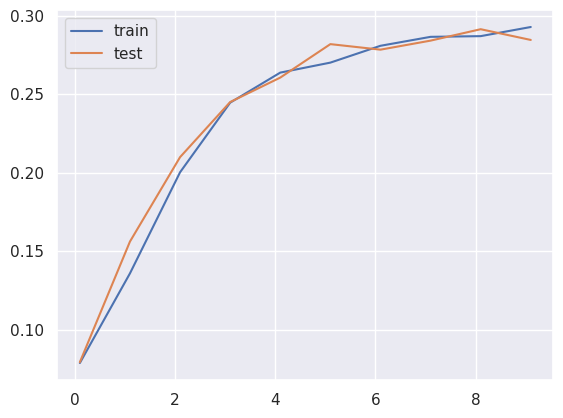

In [66]:
plt.plot(SIGMAS, loss_noise_train[:, -1], label='train')
plt.plot(SIGMAS, loss_noise_test[:, -1], label='test')
plt.legend()

In [72]:
def train_noise(net, dataloader, criterion, optimizer, sigma):
    net.train()
    total_loss = 0
    classification_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(x_batch)
        loss = criterion(y_pred, y_batch)
        classification_loss += classification(y_pred, y_batch).item()
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        for param in model.parameters():
            noise = torch.rand_like(param.grad) * sigma
            param.grad += noise
    return total_loss / len(dataloader), classification_loss / len(dataloader)


In [73]:
loss_noise_train = np.empty((len(SIGMAS), epochs))
loss_noise_test = np.empty((len(SIGMAS), epochs))


for i in tqdm(range(len(SIGMAS))):
    model = MyNet(6, 10).to(device)
    loss = nn.BCELoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs), leave=False):
        tr = train_noise(model, train_dataloader, loss, optim, SIGMAS[i])
        tst = validation(model, test_dataloader, loss, optim)
        loss_noise_train[i][epoch] = tr[0]
        loss_noise_test[i][epoch] = tst[0]

        if epoch % 50 == 0:
            print(f"loss on the {epoch}'s epoch is {tst[0]}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.1503852605819702
loss on the 50's epoch is 0.08298244327306747
loss on the 100's epoch is 0.07850532978773117
loss on the 150's epoch is 0.07628438621759415
loss on the 200's epoch is 0.07417845726013184
loss on the 250's epoch is 0.07257486134767532


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 0.9538987278938293
loss on the 50's epoch is 0.08586733788251877
loss on the 100's epoch is 0.07741652429103851
loss on the 150's epoch is 0.07512791454792023
loss on the 200's epoch is 0.07323885709047318
loss on the 250's epoch is 0.07133796066045761


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.3301066160202026
loss on the 50's epoch is 0.08400719612836838
loss on the 100's epoch is 0.08319864422082901
loss on the 150's epoch is 0.08215893059968948
loss on the 200's epoch is 0.07991575449705124
loss on the 250's epoch is 0.07817203551530838


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.64429771900177
loss on the 50's epoch is 0.08331083506345749
loss on the 100's epoch is 0.07719209045171738
loss on the 150's epoch is 0.0775238573551178
loss on the 200's epoch is 0.07359032332897186
loss on the 250's epoch is 0.07199797034263611


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.5665578842163086
loss on the 50's epoch is 0.08865326642990112
loss on the 100's epoch is 0.07703232020139694
loss on the 150's epoch is 0.07493530958890915
loss on the 200's epoch is 0.07229699194431305
loss on the 250's epoch is 0.07158877700567245


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 0.8590213656425476
loss on the 50's epoch is 0.08591028302907944
loss on the 100's epoch is 0.07803633064031601
loss on the 150's epoch is 0.07528027892112732
loss on the 200's epoch is 0.07292042672634125
loss on the 250's epoch is 0.07115236669778824


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.1748672723770142
loss on the 50's epoch is 0.08120603114366531
loss on the 100's epoch is 0.0766298770904541
loss on the 150's epoch is 0.07365891337394714
loss on the 200's epoch is 0.07206593453884125
loss on the 250's epoch is 0.0700211450457573


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.150418996810913
loss on the 50's epoch is 0.08304524421691895
loss on the 100's epoch is 0.07655143737792969
loss on the 150's epoch is 0.07368000596761703
loss on the 200's epoch is 0.07951869070529938
loss on the 250's epoch is 0.0773935317993164


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 0.4398545026779175
loss on the 50's epoch is 0.08052535355091095
loss on the 100's epoch is 0.07695859670639038
loss on the 150's epoch is 0.0751466304063797
loss on the 200's epoch is 0.07372361421585083
loss on the 250's epoch is 0.07231555879116058


  0%|          | 0/300 [00:00<?, ?it/s]

loss on the 0's epoch is 1.8303180932998657
loss on the 50's epoch is 0.08083291351795197
loss on the 100's epoch is 0.08401823788881302
loss on the 150's epoch is 0.08098287880420685
loss on the 200's epoch is 0.07863611727952957
loss on the 250's epoch is 0.07681263983249664


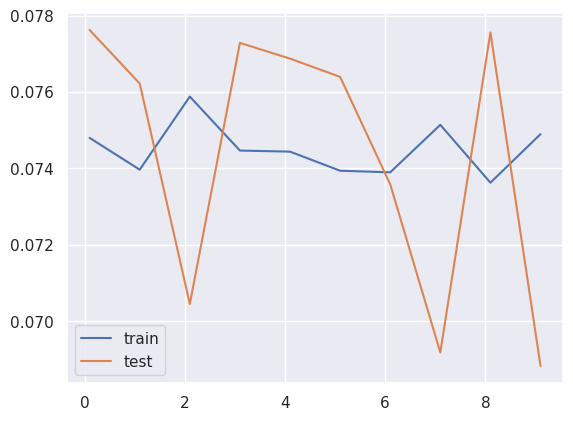

In [74]:
plt.plot(SIGMAS, loss_noise_train[:, -1], label='train')
plt.plot(SIGMAS, loss_noise_test[:, -1], label='test')
plt.legend()